In [1]:
# Set up Notebook
%matplotlib inline

# We do this to ignore several specific Pandas warnings
import warnings
warnings.filterwarnings('ignore')


# Standard imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from matplotlib import cm

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV

from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression


### Read in data

In [2]:
mw_hh= pd.read_csv('data/clean/dataset/mw_dataset_hh.csv')
tz_hh= pd.read_csv('data/clean/dataset/tz_dataset_hh_nodup.csv')
ug_hh= pd.read_csv('data/clean/dataset/ug_dataset_hh_nodup.csv')

mw_hh = mw_hh.drop(['lat_modified','lon_modified','HHID'],axis=1)
tz_hh = tz_hh.drop(['yearmon','lat_modified','lon_modified'],axis=1)
ug_hh = ug_hh.drop(['lat_modified','lon_modified','HHID'],axis=1)



# check for any missing values (should return false)
print(ug_hh.isnull().values.any())
print(mw_hh.isnull().values.any())
print(tz_hh.isnull().values.any())

False
False
False


In [3]:
mw_village = mw_hh.groupby(['FS_year','ea_id']).mean()
tz_village = tz_hh.groupby(['FS_year','ea_id']).mean()
ug_village = ug_hh.groupby(['FS_year','ea_id']).mean()

# check for any missing values (should return false)
print(ug_village.isnull().values.any())
print(tz_village.isnull().values.any())
print(mw_village.isnull().values.any())


False
False
False


In [4]:
mw_2016= mw_village.reset_index()[mw_village.reset_index()['FS_year']>2015]
mw_2016.sort_values(by=['FS_year','ea_id']).shape

(782, 73)

### Generate different outcome variable

In [5]:
def categorize_fs_three(df, measure):
    '''
    helper function to categorize continous food measure based on given cutoffs to cut into three categories 
    '''
    
    if ( measure == 'FCS'):
        labels = [2,1,0]
        bins= [-1,28,42,200]
        
    elif (measure == 'rCSI'):   
        labels = [0,1,2]
        bins= [-1,4,17,50]
        
    categorized = measure + '_3_category'
    
    df[categorized] = pd.cut( x= df[measure], bins = bins, labels = labels)
    
    df[categorized] = pd.to_numeric(df[categorized])
    
    return df 

def categorize_fs_binary_safe(df, measure):
    '''
    helper function to categorize continous food measure based on binary cutoffs
    '''
    if ( measure == 'FCS'):
        labels = [1,0]
        bins= [-1,42,200]
        
    elif (measure == 'rCSI'):   
        labels = [0,1]
        bins= [-1,4,50]
        
    categorized = measure + '_binary_safe'
    
    df[categorized] = pd.cut( x= df[measure], bins = bins, labels = labels)
    df[categorized] = pd.to_numeric(df[categorized])

    return df 

def categorize_fs_binary_bad(df, measure):
    '''
    helper function to categorize continous food measure based on binary cutoffs
    '''
    if ( measure == 'FCS'):
        labels = [1,0]
        bins= [-1,28,200]
        
    elif (measure == 'rCSI'):   
        labels = [0,1]
        bins= [-1,17,50]
        
    categorized = measure + '_binary_bad'
    
    df[categorized] = pd.cut( x= df[measure], bins = bins, labels = labels)
    df[categorized] = pd.to_numeric(df[categorized])

    
    return df 

def category_percent(df,measure):
    '''
    helper function to 
    calculate the percent of a certain food security category in a given country 
    
    watch out for counting not counting the NAs    
    '''
    categorized = measure + '_3_category'
    
    # count each category 
    df_value_counts = df.groupby(['ea_id','FS_year'])[categorized].value_counts()
    
    # flatten to columns 
    df_value_counts_name =pd.DataFrame(df_value_counts).rename(columns={categorized: measure+'_count'}) 

    df_count = df_value_counts_name.reset_index().set_index(['ea_id','FS_year',categorized]).unstack(level=-1).fillna(0).reset_index(level=['FS_year','ea_id'])
    
    # rename columns 
    df_count['total'] = df_count[measure+'_count',0]+df_count[measure+'_count',1]+df_count[measure+'_count',2]
    df_count[(measure + '_secure_percent')]= df_count[measure+'_count',0]/df_count['total']
    df_count[(measure + '_mid_percent')]= df_count[measure+'_count',1]/df_count['total']
    df_count[(measure + '_low_percent')]= df_count[measure+'_count',2]/df_count['total']
    df_count[(measure + '_mid+low')]= df_count[measure+'_mid_percent']+df_count[measure+'_low_percent']
    
     
    df_percent = df_count[['ea_id','FS_year',(measure+'_mid+low'),(measure+'_low_percent')]]
    df_percent.columns= ['ea_id','FS_year',(measure+'_mid+low'),(measure+'_low_percent')]
    
    return df_percent

def village_percent(df_village,df_hh,measure): 
    '''
    calculate and merge the percent numbers into village level dfs
    '''
    
    df_hh=categorize_fs_three(df_hh,measure=measure)
    
    df_percent = category_percent(df_hh,measure=measure)    
    
    
    df_village=categorize_fs_three(df_village,measure=measure)
    df_village=categorize_fs_binary_safe(df_village,measure=measure)
    df_village=categorize_fs_binary_bad(df_village,measure=measure)
        
    return df_percent

In [6]:
df_village_list = [mw_village,tz_village,ug_village]
#df_village_list = [mw_village]
df_hh_list = [mw_hh,tz_hh,ug_hh]
measure_list = ['FCS','rCSI']
 
for index in range(len(df_village_list)):
      
    fcs_percent = village_percent(df_village_list[index],df_hh_list[index],measure='FCS') 
    df_village_list[index] = pd.merge(df_village_list[index],fcs_percent,on=['ea_id','FS_year'])

    
    if index<2:
        rsci_percent = village_percent(df_village_list[index],df_hh_list[index],measure='rCSI') 
        df_village_list[index] = pd.merge(df_village_list[index],rsci_percent,on=['ea_id','FS_year'])
                                  

mw_village = df_village_list[0]   
tz_village = df_village_list[1]
ug_village = df_village_list[2]


### Train Test split


In [7]:
def year_split(country, df):
    if country == "mw":
        test_year = 2015
    elif country == "tz":
        test_year = 2013
    elif country == "ug":
        test_year = 2011
    
    df_test = df[df['FS_year']>test_year]
    df_train = df[df['FS_year']<test_year]

    return df_test,df_train 
          

def separate_y(country,df_test,df_train):
    if country != "ug":
        labels = ['FCS', 'rCSI']
        category_labels = ['FCS_3_category', 'FCS_binary_bad','FCS_binary_safe', 'rCSI_3_category','rCSI_binary_bad','rCSI_binary_safe']
        percent_labels = ['FCS_low_percent','FCS_mid+low','rCSI_low_percent', 'rCSI_mid+low']
               
    elif country == "ug":      
        labels = ['FCS']
        category_labels = ['FCS_3_category', 'FCS_binary_bad','FCS_binary_safe']
        percent_labels = ['FCS_low_percent','FCS_mid+low']
    
    id_vars = ["ea_id","FS_year","HDDS"]
    X_test = df_test.drop(labels+category_labels+percent_labels+id_vars,  axis=1)
    X_train = df_train.drop(labels+category_labels+percent_labels+id_vars,  axis=1)
    y_train_category = df_train[category_labels]
    y_test_category = df_test[category_labels]
    y_train_percent = df_train[percent_labels]
    y_test_percent = df_test[percent_labels]

    return X_train,X_test,y_train_category,y_test_category,y_train_percent,y_test_percent

## Model pipeline

### classifier define

In [8]:
def lrCLF(X_train,y_train,X_test, y_test,prob=False):
    '''logistic'''
    # weights = {0:1.0, 1:1000.0}
    weights = {0:1.0, 1:1}
    lr_clf = LogisticRegression(random_state=66, solver='lbfgs',
                              class_weight=weights)
    
    
    lr_clf.fit(X_train, y_train)    
    y_pred = lr_clf.predict(X_test)
     
    if prob==False:
        y_pred = lr_clf.predict(X_test)
        return y_pred,y_test
    else:
        y_prob = lr_clf.predict_proba(X_test.values)[:, 1]
        return y_prob,y_test

def lr_weighted_CLF(X_train,y_train,X_test, y_test,prob=False):
    '''weighted logistic'''
    weights = {0:1.0, 1:1000.0}
    #weights = {0:1.0, 1:1}
    lr_clf = LogisticRegression(random_state=66, solver='lbfgs')
    
    balance = [{0:100,1:1}, {0:10,1:1}, {0:1,1:1}, {0:1,1:10}, {0:1,1:100}]
    param_grid = dict(class_weight=balance)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    
        
    # define grid search
    grid = GridSearchCV(estimator=lr_clf, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='recall')
    grid_result = grid.fit(X_train, y_train)    

    
       # report the best configuration
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    # report all configurations
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))

             
    if prob==False:
        y_pred = grid_result.predict(X_test)
        return y_pred,y_test
    else:
        y_prob = grid_result.predict_proba(X_test.values)[:, 1]
        return y_prob,y_test
    
    
def rfCLF(X_train,y_train,X_test, y_test,prob=False):
    
    '''rfc'''

    rf_clf = RandomForestClassifier(n_estimators = 500,
                                    class_weight = 'balanced',
                                    min_samples_split=10,
                                    
                                    warm_start=True)

    # Define rfc classifier
    max_depth = [int(x) for x in np.linspace(6, 9, num = 3)]
    max_features = [int(x) for x in np.linspace(10, 12, num = 3)]
    weights = [  "balanced_subsample","balanced", {0:1.0, 1:100.0},{0:1.0, 1:1000.0}]
    # weights = ["balanced"]

    random_grid = {#'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'class_weight':weights
                   #'min_samples_split': min_samples_split
                   #'min_samples_leaf': min_samples_leaf}
                   #'bootstrap': bootstrap
                    }
    
    rf_random = GridSearchCV(estimator = rf_clf, 
            #param_distributions = random_grid,
            param_grid = random_grid,                 
            scoring ='recall', 
            cv = 3, verbose=0, 
            n_jobs = -1)


    # Fit the random search model
    rf_random.fit(X_train, y_train)
    
    print('rf-best params are')
    print(rf_random.best_params_)
    
    if prob==False:
        y_pred = rf_random.predict(X_test)
        return y_pred,y_test
    else:
        y_prob = rf_random.predict_proba(X_test.values)[:, 1]
        return y_prob,y_test
    
 
     

def xgbCLF(X_train,y_train,X_test, y_test,prob=False):
    '''XGB'''

    # fit model on  training data
    XGB_clf = XGBClassifier(silent=False, 
                           learning_rate=0.2,  
                           subsample = 0.8,
                           objective='binary:logistic', 
                           n_estimators=100, 
                           reg_alpha = 0.3)
                          
    
    max_depth = [int(x) for x in np.linspace(3, 15, num = 10)]
    max_features = [int(x) for x in np.linspace(3, 15, num = 10)]
    weights = [  "balanced_subsample","balanced", {0:1.0, 1:100.0},{0:1.0, 1:1000.0}]
    # weights = ["balanced"]
    random_grid = {'max_features': max_features,'max_depth': max_depth,'class_weight':weights}
 
    XGB_random = RandomizedSearchCV(estimator = XGB_clf, 
                                             scoring ='recall',param_distributions = random_grid,n_iter = 30, cv = 3, verbose=2, random_state=666, n_jobs = -1)

 
    
    # Fit the random search model
    X_train = X_train.to_numpy()
    X_test = X_test.to_numpy()
    
    XGB_random.fit(X_train, y_train)
    
    print('xgb-best params are')
    print(XGB_random.best_params_)

    
    if prob==False:
        y_pred = XGB_random.predict(X_test)
        return y_pred,y_test
    else:
        y_prob = XGB_random.predict_proba(X_test)[:, 1]
        return y_prob,y_test    

### ROC and Precision-Recall Curve for binary outcome

In [9]:
def get_roc(y_prob,y_true):
    pos = y_true[y_true==1]
    neg = y_true[y_true==0]
    threshold = np.sort(y_prob)[::-1]
    y = y_true.to_numpy()[y_prob.argsort()[::-1]]
    tpr_all = [0] ; fpr_all = [0]
    tpr = 0 ; fpr = 0
    x_step = 1/float(len(neg))
    y_step = 1/float(len(pos))
    y_sum = 0                             
    for i in range(len(threshold)):
        if y[i] == 1:
            tpr += y_step
            tpr_all.append(tpr)
            fpr_all.append(fpr)
        else:
            fpr += x_step
            fpr_all.append(fpr)
            tpr_all.append(tpr)
            y_sum += tpr
            
    return tpr_all,fpr_all,y_sum*x_step

def get_pr(y_prob,y_true):
    pos = y_true[y_true==1]
    threshold = np.sort(y_prob)[::-1]
    y = y_true.to_numpy()[y_prob.argsort()[::-1]]
    recall = [] ; precision = []
    tp = 0 ; fp = 0
    # y_step = 1/float(len(pos))
    auc = 0
    for i in range(len(threshold)):
        if y[i] == 1:
            tp += 1
            recall.append(tp/len(pos))
            precision.append(tp/(tp+fp))
            auc += (recall[i]-recall[i-1])*precision[i]
        else:
            fp += 1
            recall.append(tp/len(pos))
            precision.append(tp/(tp+fp))
            
    return precision,recall,auc

explore the relative distribution of our binary cases

In [10]:
def roc_pr_values(country,df,measure,cut):
    
    category = measure+'_binary_'+cut

    df_test,df_train = year_split(country, df)
    X_train,X_test,y_train_category,y_test_category,y_train_percent,y_test_percent = separate_y(country,df_test,df_train)

    # baseline
    y_prob,y_test  = lrCLF(X_train,y_train_category[category],X_test,y_test_category[category],prob=True)
    tpr_lr,fpr_lr,auc_roc_lr = get_roc(y_prob,y_test)  
    precision_lr,recall_lr,auc_pr_lr = get_pr(y_prob,y_test)

    # fpr_lr, tpr_lr, thresholds = roc_curve(y_test, y_prob)
    # auc_lr = auc(fpr_lr, tpr_lr)
    
    
    # lr weighted
    y_prob,y_test  = lr_weighted_CLF(X_train,y_train_category[category],X_test,y_test_category[category],prob=True)
    tpr_lr_w,fpr_lr_w,auc_roc_lr_w = get_roc(y_prob,y_test)  
    precision_lr_w,recall_lr_w,auc_pr_lr_w = get_pr(y_prob,y_test)
    
    
    # rf
    y_prob,y_test  = rfCLF(X_train,y_train_category[category],X_test,y_test_category[category],prob=True)
    tpr_rf,fpr_rf,auc_roc_rf = get_roc(y_prob,y_test)  
    precision_rf,recall_rf,auc_pr_rf = get_pr(y_prob,y_test)

    # fpr_rf, tpr_rf, thresholds = roc_curve(y_test, y_prob)
    # auc_rf = auc(fpr_rf, tpr_rf)
    
    # xgb 
    y_prob,y_test  = xgbCLF(X_train,y_train_category[category],X_test,y_test_category[category],prob=True)
    tpr_xgb,fpr_xgb,auc_roc_xgb = get_roc(y_prob,y_test)  
    precision_xgb,recall_xgb,auc_pr_xgb = get_pr(y_prob,y_test)

    #fpr_xgb, tpr_xgb, thresholds = roc_curve(y_test, y_prob)
    #auc_xgb = auc(fpr_xgb, tpr_xgb)
    
    roc_lr = [tpr_lr,fpr_lr,auc_roc_lr]
    pr_lr = [precision_lr,recall_lr,auc_pr_lr]
    
    roc_lr_w = [tpr_lr_w,fpr_lr_w,auc_roc_lr_w]
    pr_lr_w = [precision_lr_w,recall_lr_w,auc_pr_lr_w]
    
    roc_rf = [tpr_rf,fpr_rf,auc_roc_rf]
    pr_rf = [precision_rf,recall_rf,auc_pr_rf]
    
    roc_xgb = [tpr_xgb,fpr_xgb,auc_roc_xgb]
    pr_xgb = [precision_xgb,recall_xgb,auc_pr_xgb]
    
    return roc_lr,pr_lr,roc_lr_w,pr_lr_w,roc_rf,pr_rf,roc_xgb,pr_xgb
    
def ROC_curve_plot(roc_lr,roc_lr_w,roc_rf,roc_xgb):
    '''
    roc curve plotting
    '''
    
    print("start printing ROC curve")
    
    tpr_lr = roc_lr[0]
    fpr_lr = roc_lr[1]
    auc_lr = roc_lr[2]
    
    tpr_lr_w = roc_lr_w[0]
    fpr_lr_w = roc_lr_w[1]
    auc_lr_w = roc_lr_w[2]
    
    
    tpr_rf = roc_rf[0]
    fpr_rf = roc_rf[1]
    auc_rf = roc_rf[2]
    
    tpr_xgb = roc_xgb[0]
    fpr_xgb = roc_xgb[1]
    auc_xgb = roc_xgb[2]
    
    
    # ROC curve 
    plt.figure(figsize=(10,6))
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.plot(fpr_lr,tpr_lr,label="Logistic Regression (AUC: {:.3f})".format(auc_lr),linewidth=2)
    plt.plot(fpr_lr_w,tpr_lr_w,label="Weighted Logistic Regression (AUC: {:.3f})".format(auc_lr_w),linewidth=2)
    plt.plot(fpr_rf,tpr_rf,label="Random Forest (AUC: {:.3f})".format(auc_rf),linewidth=2)
    plt.plot(fpr_xgb,tpr_xgb,label="Gradient Boosting (AUC: {:.3f})".format(auc_xgb),linewidth=2)
    
    plt.xlabel("False Positive Rate",fontsize=16)
    plt.ylabel("True Positive Rate",fontsize=16)
    plt.title("ROC Curve",fontsize=16)
    plt.legend(loc="lower right",fontsize=16) 

    # plt.savefig('output/graphs/roc/'+country+'_'+measure+cut+'_roc.png', bbox_inches='tight')
    
    return plt.show()
    
    
def pr_curve_plot(pr_lr,pr_lr_w,pr_rf,pr_xgb):
    '''
    pr curve plotting
    '''
    
    print("start printing ROC curve")
    precision_lr = pr_lr[0]
    recall_lr = pr_lr[1]
    auc_pr_lr = pr_lr[2]
    
    precision_lr_w = pr_lr_w[0]
    recall_lr_w = pr_lr_w[1]
    auc_pr_lr_w = pr_lr_w[2]
    
    precision_rf = pr_rf[0]
    recall_rf = pr_rf[1]
    auc_pr_rf = pr_rf[2]
    
    precision_xgb = pr_xgb[0]
    recall_xgb = pr_xgb[1]
    auc_pr_xgb = pr_xgb[2]
    
    # PR CURVE 
    plt.figure(figsize=(10,6))
    plt.plot(recall_lr,precision_lr,label="Logistic Regression (AUC: {:.3f})".format(auc_pr_lr),linewidth=2)
    plt.plot(recall_lr_w,precision_lr_w,label="Weighted Logistic Regression (AUC: {:.3f})".format(auc_pr_lr_w),linewidth=2)
    plt.plot(recall_rf,precision_rf,label="Random Forest (AUC: {:.3f})".format(auc_pr_rf),linewidth=2)
    plt.plot(recall_xgb,precision_xgb,label="Gradient Boosting (AUC: {:.3f})".format(auc_pr_xgb),linewidth=2)

    plt.xlabel("Recall",fontsize=16)
    plt.ylabel("Precision",fontsize=16)
    plt.title("Precision Recall Curve",fontsize=17)
    plt.legend(fontsize=16)
    
    # plt.savefig('output/graphs/pr/'+country+'_'+measure+cut+'_pr.png', bbox_inches='tight')

    
    return plt.show()


In [11]:
print(mw_village[mw_village['FS_year']>2015]['FCS_binary_bad'].value_counts())
print(mw_village[mw_village['FS_year']>2015]['rCSI_binary_bad'].value_counts())

print(tz_village[tz_village['FS_year']>2013]['FCS_binary_bad'].value_counts())
print(tz_village[tz_village['FS_year']>2013]['rCSI_binary_bad'].value_counts())

print(ug_village[ug_village['FS_year']>2011]['FCS_binary_bad'].value_counts())

0    771
1     11
Name: FCS_binary_bad, dtype: int64
0    723
1     59
Name: rCSI_binary_bad, dtype: int64
0    311
1      1
Name: FCS_binary_bad, dtype: int64
0    307
1      5
Name: rCSI_binary_bad, dtype: int64
0    308
1      7
Name: FCS_binary_bad, dtype: int64


In [12]:
print(mw_village[mw_village['FS_year']<2015]['FCS_binary_bad'].value_counts())
print(mw_village[mw_village['FS_year']<2015]['rCSI_binary_bad'].value_counts())

print(tz_village[tz_village['FS_year']<2013]['FCS_binary_bad'].value_counts())
print(tz_village[tz_village['FS_year']<2013]['rCSI_binary_bad'].value_counts())

print(ug_village[ug_village['FS_year']<2011]['FCS_binary_bad'].value_counts())

0    960
1     12
Name: FCS_binary_bad, dtype: int64
0    970
1      2
Name: rCSI_binary_bad, dtype: int64
0    633
1      8
Name: FCS_binary_bad, dtype: int64
0    627
1     14
Name: rCSI_binary_bad, dtype: int64
0    324
1     10
Name: FCS_binary_bad, dtype: int64


In [259]:
from sklearn.metrics import classification_report

def classification_rep_threshold(country,df,measure,cut,threshold):
    
    category = measure+'_binary_'+cut
    
    df_test,df_train = year_split(country, df)
    X_train,X_test,y_train_category,y_test_category,y_train_percent,y_test_percent = separate_y(country,df_test,df_train)
    
    class_names = ['majority_class','minority_class']
    
    # baseline
    y_prob,y_test  = lrCLF(X_train,y_train_category[category],X_test,y_test_category[category],prob=True)
    y_pred = np.where(y_prob>= threshold,1,0)
    
    print ("----------------base model---------------- \n",
           classification_report(y_test, y_pred, target_names = class_names),'\n'  )
        
    # weighted lr 
    y_prob,y_test  = lr_weighted_CLF(X_train,y_train_category[category],X_test,y_test_category[category],prob=True)
    y_pred = np.where(y_prob>= threshold,1,0)
    
    print ("----------------weighted lr model---------------- \n",
           classification_report(y_test, y_pred, target_names = class_names),'\n'  )
        
    
    
    # rf
    y_prob,y_test  = rfCLF(X_train,y_train_category[category],X_test,y_test_category[category],prob=True)
    y_pred = np.where(y_prob>= threshold,1,0)
    
    print ("----------------rfc model---------------- \n",
           classification_report(y_test, y_pred, target_names = class_names),'\n'  )
   
    
    # xgb 
    y_prob,y_test  = xgbCLF(X_train,y_train_category[category],X_test,y_test_category[category],prob=True)
    y_pred = np.where(y_prob>= threshold,1,0)
    
    print ("----------------xgb model---------------- \n",
           classification_report(y_test, y_pred, target_names = class_names),'\n'  )
   
    


In [257]:
from sklearn.metrics import classification_report

def classification_rep_ss(country,df,measure,cut,threshold):
    
    category = measure+'_binary_'+cut
    
    df_test,df_train = year_split(country, df)
    X_train,X_test,y_train_category,y_test_category,y_train_percent,y_test_percent = separate_y(country,df_test,df_train)
    
    class_names = ['majority_class','minority_class']
    
    
    # baseline
    y_prob,y_test  = lrCLF(X_train,y_train_category[category],X_test,y_test_category[category],prob=True)
    fpr1, tpr1, thresholds1 = roc_curve(y_test, y_prob)
    roc_auc1 = auc(fpr1, tpr1) # compute area under the curve
 
        
    # weighted lr 
    y_prob,y_test  = lr_weighted_CLF(X_train,y_train_category[category],X_test,y_test_category[category],prob=True)
    #y_pred = np.where(y_prob>= threshold,1,0)
    fpr2, tpr2, thresholds2 = roc_curve(y_test, y_prob)
    roc_auc2 = auc(fpr2, tpr2) # compute area under the curve
 
 
    
    
    # rf
    y_prob,y_test  = rfCLF(X_train,y_train_category[category],X_test,y_test_category[category],prob=True)
    y_pred = np.where(y_prob>= threshold,1,0)
    fpr3, tpr3, thresholds3 = roc_curve(y_test, y_prob)
    roc_auc3 = auc(fpr3, tpr3) # compute area under the curve
 
   
    # xgb 
    y_prob,y_test  = xgbCLF(X_train,y_train_category[category],X_test,y_test_category[category],prob=True)
    y_pred = np.where(y_prob>= threshold,1,0)
    fpr4, tpr4, thresholds4 = roc_curve(y_test, y_prob)
    roc_auc4 = auc(fpr4, tpr4) # compute area under the curve
 
 
    
    plt.figure()
    plt.plot(fpr1, tpr1, label='ROC curve (area = %0.2f)' % (roc_auc1))
    plt.plot(fpr2, tpr2, label='ROC curve (area = %0.2f)' % (roc_auc2))
    plt.plot(fpr3, tpr3, label='ROC curve (area = %0.3f)' % (roc_auc3))
    plt.plot(fpr4, tpr4, label='ROC curve (area = %0.4f)' % (roc_auc4))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")

    # create the axis of thresholds (scores)
    ax2 = plt.gca().twinx()
    ax2.plot(fpr3, thresholds3, markeredgecolor='r',linestyle='dashed', color='r')
    ax2.set_ylabel('Threshold',color='r')
    ax2.set_ylim([thresholds3[-1],thresholds3[0]])
    ax2.set_xlim([fpr3[0],fpr3[-1]])

    plt.show()
    


Best: 0.333333 using {'class_weight': {0: 1, 1: 100}}
0.000000 (0.000000) with: {'class_weight': {0: 100, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 10, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 1, 1: 1}}
0.166667 (0.372678) with: {'class_weight': {0: 1, 1: 10}}
0.333333 (0.471405) with: {'class_weight': {0: 1, 1: 100}}
rf-best params are
{'class_weight': 'balanced_subsample', 'max_depth': 6, 'max_features': 10}
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    3.2s finished


xgb-best params are
{'max_features': 5, 'max_depth': 5, 'class_weight': 'balanced_subsample'}


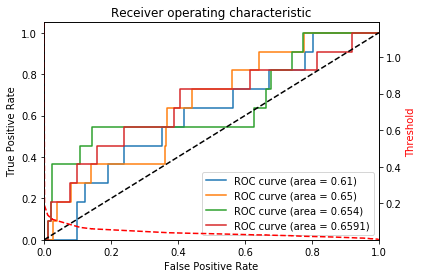

Best: 0.000000 using {'class_weight': {0: 100, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 100, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 10, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 1, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 1, 1: 10}}
0.000000 (0.000000) with: {'class_weight': {0: 1, 1: 100}}
rf-best params are
{'class_weight': 'balanced_subsample', 'max_depth': 6, 'max_features': 10}
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.3s finished


xgb-best params are
{'max_features': 5, 'max_depth': 5, 'class_weight': 'balanced_subsample'}


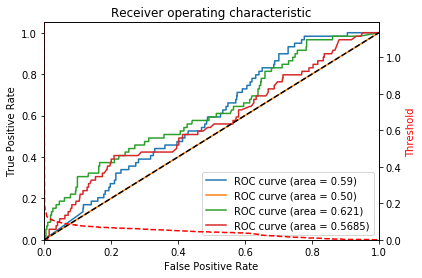

Best: 0.400000 using {'class_weight': {0: 1, 1: 100}}
0.000000 (0.000000) with: {'class_weight': {0: 100, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 10, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 1, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 1, 1: 10}}
0.400000 (0.489898) with: {'class_weight': {0: 1, 1: 100}}
rf-best params are
{'class_weight': 'balanced_subsample', 'max_depth': 6, 'max_features': 10}
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.5s finished


xgb-best params are
{'max_features': 5, 'max_depth': 5, 'class_weight': 'balanced_subsample'}


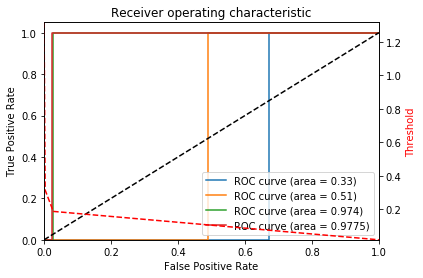

Best: 0.283333 using {'class_weight': {0: 1, 1: 100}}
0.000000 (0.000000) with: {'class_weight': {0: 100, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 10, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 1, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 1, 1: 10}}
0.283333 (0.401732) with: {'class_weight': {0: 1, 1: 100}}
rf-best params are
{'class_weight': 'balanced', 'max_depth': 6, 'max_features': 12}
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    3.1s finished


xgb-best params are
{'max_features': 5, 'max_depth': 5, 'class_weight': 'balanced_subsample'}


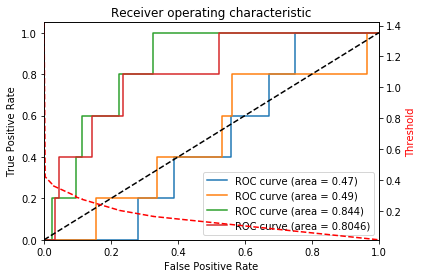

Best: 0.433333 using {'class_weight': {0: 1, 1: 100}}
0.000000 (0.000000) with: {'class_weight': {0: 100, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 10, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 1, 1: 1}}
0.300000 (0.458258) with: {'class_weight': {0: 1, 1: 10}}
0.433333 (0.495536) with: {'class_weight': {0: 1, 1: 100}}
rf-best params are
{'class_weight': 'balanced_subsample', 'max_depth': 6, 'max_features': 10}
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    0.6s finished


xgb-best params are
{'max_features': 5, 'max_depth': 5, 'class_weight': 'balanced_subsample'}


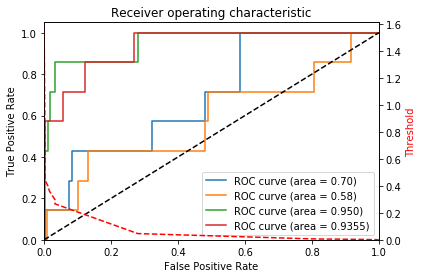

In [283]:
country_list = ["mw","tz","ug"]
measure_list = ["FCS","rCSI"]

for country in country_list:
    for measure in measure_list:
        if (measure=="rCSI") & (country=="ug"):
            pass
        else:
            if country=="mw":
                df = mw_village
            elif country == "ug":
                df = ug_village
            elif country == "tz":
                df = tz_village
                
            classification_rep_ss(country,df,measure,cut='bad',threshold=0.3)    

In [287]:
classification_rep_threshold("mw",mw_village,"FCS",cut='bad',threshold=0.01 )

----------------base model---------------- 
                 precision    recall  f1-score   support

majority_class       0.99      0.78      0.87       771
minority_class       0.02      0.36      0.04        11

      accuracy                           0.77       782
     macro avg       0.51      0.57      0.46       782
  weighted avg       0.97      0.77      0.86       782
 

Best: 0.333333 using {'class_weight': {0: 1, 1: 100}}
0.000000 (0.000000) with: {'class_weight': {0: 100, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 10, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 1, 1: 1}}
0.166667 (0.372678) with: {'class_weight': {0: 1, 1: 10}}
0.333333 (0.471405) with: {'class_weight': {0: 1, 1: 100}}
----------------weighted lr model---------------- 
                 precision    recall  f1-score   support

majority_class       0.99      0.50      0.66       771
minority_class       0.02      0.73      0.04        11

      accuracy                           0.50  

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.1s


xgb-best params are
{'max_features': 9, 'max_depth': 9, 'class_weight': 'balanced_subsample'}
----------------xgb model---------------- 
                 precision    recall  f1-score   support

majority_class       0.99      0.74      0.85       771
minority_class       0.03      0.55      0.06        11

      accuracy                           0.74       782
     macro avg       0.51      0.64      0.45       782
  weighted avg       0.98      0.74      0.84       782
 



[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    3.3s finished


In [295]:
classification_rep_threshold("mw",mw_village,"rCSI",cut='bad',threshold=0.02 )

----------------base model---------------- 
                 precision    recall  f1-score   support

majority_class       0.93      0.77      0.84       723
minority_class       0.10      0.32      0.16        59

      accuracy                           0.74       782
     macro avg       0.52      0.55      0.50       782
  weighted avg       0.87      0.74      0.79       782
 

Best: 0.000000 using {'class_weight': {0: 100, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 100, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 10, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 1, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 1, 1: 10}}
0.000000 (0.000000) with: {'class_weight': {0: 1, 1: 100}}
----------------weighted lr model---------------- 
                 precision    recall  f1-score   support

majority_class       0.92      1.00      0.96       723
minority_class       0.00      0.00      0.00        59

      accuracy                           0.92  

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.1s


xgb-best params are
{'max_features': 9, 'max_depth': 9, 'class_weight': 'balanced_subsample'}
----------------xgb model---------------- 
                 precision    recall  f1-score   support

majority_class       0.92      0.99      0.95       723
minority_class       0.09      0.02      0.03        59

      accuracy                           0.91       782
     macro avg       0.51      0.50      0.49       782
  weighted avg       0.86      0.91      0.88       782
 



[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.2s finished


In [299]:
classification_rep_threshold("tz",tz_village,"rCSI",cut='bad',threshold=0.1)

----------------base model---------------- 
                 precision    recall  f1-score   support

majority_class       0.98      0.99      0.99       307
minority_class       0.00      0.00      0.00         5

      accuracy                           0.97       312
     macro avg       0.49      0.50      0.49       312
  weighted avg       0.97      0.97      0.97       312
 

Best: 0.283333 using {'class_weight': {0: 1, 1: 100}}
0.000000 (0.000000) with: {'class_weight': {0: 100, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 10, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 1, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 1, 1: 10}}
0.283333 (0.401732) with: {'class_weight': {0: 1, 1: 100}}
----------------weighted lr model---------------- 
                 precision    recall  f1-score   support

majority_class       0.99      0.45      0.62       307
minority_class       0.02      0.60      0.03         5

      accuracy                           0.45  

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.0s


xgb-best params are
{'max_features': 9, 'max_depth': 15, 'class_weight': 'balanced'}
----------------xgb model---------------- 
                 precision    recall  f1-score   support

majority_class       0.98      1.00      0.99       307
minority_class       0.00      0.00      0.00         5

      accuracy                           0.98       312
     macro avg       0.49      0.50      0.50       312
  weighted avg       0.97      0.98      0.98       312
 



[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    3.1s finished


In [302]:
classification_rep_threshold("tz",tz_village,"FCS",cut='bad',threshold=0.1 )

----------------base model---------------- 
                 precision    recall  f1-score   support

majority_class       1.00      1.00      1.00       311
minority_class       0.00      0.00      0.00         1

      accuracy                           0.99       312
     macro avg       0.50      0.50      0.50       312
  weighted avg       0.99      0.99      0.99       312
 

Best: 0.400000 using {'class_weight': {0: 1, 1: 100}}
0.000000 (0.000000) with: {'class_weight': {0: 100, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 10, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 1, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 1, 1: 10}}
0.400000 (0.489898) with: {'class_weight': {0: 1, 1: 100}}
----------------weighted lr model---------------- 
                 precision    recall  f1-score   support

majority_class       0.99      0.64      0.78       311
minority_class       0.00      0.00      0.00         1

      accuracy                           0.63  

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.8s


xgb-best params are
{'max_features': 9, 'max_depth': 15, 'class_weight': 'balanced'}
----------------xgb model---------------- 
                 precision    recall  f1-score   support

majority_class       1.00      1.00      1.00       311
minority_class       0.00      0.00      0.00         1

      accuracy                           0.99       312
     macro avg       0.50      0.50      0.50       312
  weighted avg       0.99      0.99      0.99       312
 



[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.4s finished


In [305]:
classification_rep_threshold("ug",tz_village,"FCS",cut='bad',threshold=0.08 )

----------------base model---------------- 
                 precision    recall  f1-score   support

majority_class       0.98      1.00      0.99       848
minority_class       0.00      0.00      0.00        13

      accuracy                           0.98       861
     macro avg       0.49      0.50      0.50       861
  weighted avg       0.97      0.98      0.98       861
 

Best: nan using {'class_weight': {0: 100, 1: 1}}
nan (nan) with: {'class_weight': {0: 100, 1: 1}}
nan (nan) with: {'class_weight': {0: 10, 1: 1}}
nan (nan) with: {'class_weight': {0: 1, 1: 1}}
nan (nan) with: {'class_weight': {0: 1, 1: 10}}
nan (nan) with: {'class_weight': {0: 1, 1: 100}}
----------------weighted lr model---------------- 
                 precision    recall  f1-score   support

majority_class       0.98      1.00      0.99       848
minority_class       0.00      0.00      0.00        13

      accuracy                           0.98       861
     macro avg       0.49      0.50      0.50 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    0.4s finished


xgb-best params are
{'max_features': 9, 'max_depth': 15, 'class_weight': 'balanced'}
----------------xgb model---------------- 
                 precision    recall  f1-score   support

majority_class       0.98      1.00      0.99       848
minority_class       0.00      0.00      0.00        13

      accuracy                           0.98       861
     macro avg       0.49      0.50      0.50       861
  weighted avg       0.97      0.98      0.98       861
 



In [248]:
def classification_rep_prob(country,df,measure,cut,threshold):
    
    category = measure+'_binary_'+cut
    
    df_test,df_train = year_split(country, df)
    X_train,X_test,y_train_category,y_test_category,y_train_percent,y_test_percent = separate_y(country,df_test,df_train)
    
    class_names = ['majority_class','minority_class']
    
    # baseline
    y_prob,y_test  = lrCLF(X_train,y_train_category[category],X_test,y_test_category[category],prob=True)
    # y_pred = np.where(y_prob>= threshold,1,0)
    
    #print ("----------------base model---------------- \n",
    #        classification_report(y_test, y_pred, target_names = class_names),'\n'  )
    
    print(np.unique(y_prob))
    
    # weighted lr 
    y_prob,y_test  = lr_weighted_CLF(X_train,y_train_category[category],X_test,y_test_category[category],prob=True)
    y_pred = np.where(y_prob>= threshold,1,0)
    
    #print ("----------------weighted lr model---------------- \n",
    #       classification_report(y_test, y_pred, target_names = class_names),'\n'  )
    
    print(np.unique(y_prob))

    
    
    # rf
    y_prob,y_test  = rfCLF(X_train,y_train_category[category],X_test,y_test_category[category],prob=True)
    y_pred = np.where(y_prob>= threshold,1,0)
    
    #print ("----------------rfc model---------------- \n",
    #       classification_report(y_test, y_pred, target_names = class_names),'\n'  )
    print(np.unique(y_prob))

    
    # xgb 
    y_prob,y_test  = xgbCLF(X_train,y_train_category[category],X_test,y_test_category[category],prob=True)
    y_pred = np.where(y_prob>= threshold,1,0)
    
    #print ("----------------xgb model---------------- \n",
    #       classification_report(y_test, y_pred, target_names = class_names),'\n'  )
    print(np.unique(y_prob))

    

In [229]:
classification_rep_threshold(country,df,measure,cut='safe',threshold=0.5)    

----------------base model---------------- 
                 precision    recall  f1-score   support

majority_class       0.52      0.73      0.61       373
minority_class       0.61      0.38      0.47       409

      accuracy                           0.55       782
     macro avg       0.56      0.56      0.54       782
  weighted avg       0.57      0.55      0.53       782
 

Best: 1.000000 using {'class_weight': {0: 1, 1: 100}}
0.000000 (0.000000) with: {'class_weight': {0: 100, 1: 1}}
0.017706 (0.023889) with: {'class_weight': {0: 10, 1: 1}}
0.330502 (0.087335) with: {'class_weight': {0: 1, 1: 1}}
0.972581 (0.026914) with: {'class_weight': {0: 1, 1: 10}}
1.000000 (0.000000) with: {'class_weight': {0: 1, 1: 100}}
----------------weighted lr model---------------- 
                 precision    recall  f1-score   support

majority_class       0.53      0.24      0.33       373
minority_class       0.54      0.81      0.65       409

      accuracy                           0.54  

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    9.0s finished


xgb-best params are
{'max_features': 8, 'max_depth': 8, 'class_weight': 'balanced_subsample'}
----------------xgb model---------------- 
                 precision    recall  f1-score   support

majority_class       0.60      0.90      0.72       373
minority_class       0.83      0.44      0.58       409

      accuracy                           0.66       782
     macro avg       0.71      0.67      0.65       782
  weighted avg       0.72      0.66      0.64       782
 

----------------base model---------------- 
                 precision    recall  f1-score   support

majority_class       0.14      0.49      0.21        96
minority_class       0.89      0.57      0.69       686

      accuracy                           0.56       782
     macro avg       0.51      0.53      0.45       782
  weighted avg       0.80      0.56      0.63       782
 

Best: 1.000000 using {'class_weight': {0: 1, 1: 100}}
0.021534 (0.031340) with: {'class_weight': {0: 100, 1: 1}}
0.098307 (0.043414) wi

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    8.8s finished


xgb-best params are
{'max_features': 9, 'max_depth': 13, 'class_weight': {0: 1.0, 1: 1000.0}}
----------------xgb model---------------- 
                 precision    recall  f1-score   support

majority_class       0.16      0.66      0.26        96
minority_class       0.92      0.53      0.67       686

      accuracy                           0.55       782
     macro avg       0.54      0.59      0.47       782
  weighted avg       0.82      0.55      0.62       782
 

----------------base model---------------- 
                 precision    recall  f1-score   support

majority_class       0.88      0.98      0.93       275
minority_class       0.14      0.03      0.05        37

      accuracy                           0.87       312
     macro avg       0.51      0.50      0.49       312
  weighted avg       0.79      0.87      0.82       312
 

Best: 1.000000 using {'class_weight': {0: 1, 1: 100}}
0.000000 (0.000000) with: {'class_weight': {0: 100, 1: 1}}
0.000000 (0.000000) wi

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    5.7s finished


xgb-best params are
{'max_features': 8, 'max_depth': 14, 'class_weight': 'balanced'}
----------------xgb model---------------- 
                 precision    recall  f1-score   support

majority_class       0.93      0.92      0.92       275
minority_class       0.42      0.46      0.44        37

      accuracy                           0.86       312
     macro avg       0.68      0.69      0.68       312
  weighted avg       0.87      0.86      0.86       312
 

----------------base model---------------- 
                 precision    recall  f1-score   support

majority_class       0.62      0.82      0.71       190
minority_class       0.44      0.22      0.30       122

      accuracy                           0.59       312
     macro avg       0.53      0.52      0.50       312
  weighted avg       0.55      0.59      0.55       312
 

Best: 1.000000 using {'class_weight': {0: 1, 1: 100}}
0.000000 (0.000000) with: {'class_weight': {0: 100, 1: 1}}
0.000000 (0.000000) with: {'cla

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    6.6s finished


xgb-best params are
{'max_features': 8, 'max_depth': 9, 'class_weight': 'balanced_subsample'}
----------------xgb model---------------- 
                 precision    recall  f1-score   support

majority_class       0.64      0.77      0.70       190
minority_class       0.48      0.34      0.40       122

      accuracy                           0.60       312
     macro avg       0.56      0.55      0.55       312
  weighted avg       0.58      0.60      0.58       312
 

----------------base model---------------- 
                 precision    recall  f1-score   support

majority_class       0.94      0.07      0.13       239
minority_class       0.25      0.99      0.40        76

      accuracy                           0.29       315
     macro avg       0.60      0.53      0.27       315
  weighted avg       0.78      0.29      0.20       315
 

Best: 1.000000 using {'class_weight': {0: 1, 1: 100}}
0.000000 (0.000000) with: {'class_weight': {0: 100, 1: 1}}
0.000000 (0.000000) wi

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s


xgb-best params are
{'max_features': 9, 'max_depth': 11, 'class_weight': {0: 1.0, 1: 1000.0}}
----------------xgb model---------------- 
                 precision    recall  f1-score   support

majority_class       0.81      0.89      0.85       239
minority_class       0.50      0.34      0.41        76

      accuracy                           0.76       315
     macro avg       0.65      0.62      0.63       315
  weighted avg       0.74      0.76      0.74       315
 



[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    1.3s finished


In [230]:
country_list = ["mw","tz","ug"]
measure_list = ["FCS","rCSI"]

for country in country_list:
    for measure in measure_list:
        if (measure=="rCSI") & (country=="ug"):
            pass
        else:
            if country=="mw":
                df = mw_village
            elif country == "ug":
                df = ug_village
            elif country == "tz":
                df = tz_village
                
            classification_rep_threshold(country,df,measure,cut='safe',threshold=0.3)    

----------------base model---------------- 
                 precision    recall  f1-score   support

majority_class       0.52      0.62      0.57       373
minority_class       0.58      0.47      0.52       409

      accuracy                           0.54       782
     macro avg       0.55      0.55      0.54       782
  weighted avg       0.55      0.54      0.54       782
 

Best: 1.000000 using {'class_weight': {0: 1, 1: 100}}
0.000000 (0.000000) with: {'class_weight': {0: 100, 1: 1}}
0.017706 (0.023889) with: {'class_weight': {0: 10, 1: 1}}
0.330502 (0.087335) with: {'class_weight': {0: 1, 1: 1}}
0.972581 (0.026914) with: {'class_weight': {0: 1, 1: 10}}
1.000000 (0.000000) with: {'class_weight': {0: 1, 1: 100}}
----------------weighted lr model---------------- 
                 precision    recall  f1-score   support

majority_class       0.52      0.17      0.26       373
minority_class       0.53      0.85      0.65       409

      accuracy                           0.53  

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    8.0s finished


xgb-best params are
{'max_features': 8, 'max_depth': 8, 'class_weight': 'balanced_subsample'}
----------------xgb model---------------- 
                 precision    recall  f1-score   support

majority_class       0.64      0.83      0.72       373
minority_class       0.79      0.57      0.66       409

      accuracy                           0.69       782
     macro avg       0.71      0.70      0.69       782
  weighted avg       0.72      0.69      0.69       782
 

----------------base model---------------- 
                 precision    recall  f1-score   support

majority_class       0.11      0.32      0.16        96
minority_class       0.87      0.63      0.73       686

      accuracy                           0.59       782
     macro avg       0.49      0.48      0.45       782
  weighted avg       0.78      0.59      0.66       782
 

Best: 1.000000 using {'class_weight': {0: 1, 1: 100}}
0.021534 (0.031340) with: {'class_weight': {0: 100, 1: 1}}
0.098307 (0.043414) wi

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    8.9s finished


xgb-best params are
{'max_features': 9, 'max_depth': 13, 'class_weight': {0: 1.0, 1: 1000.0}}
----------------xgb model---------------- 
                 precision    recall  f1-score   support

majority_class       0.18      0.39      0.24        96
minority_class       0.90      0.75      0.82       686

      accuracy                           0.70       782
     macro avg       0.54      0.57      0.53       782
  weighted avg       0.81      0.70      0.75       782
 

----------------base model---------------- 
                 precision    recall  f1-score   support

majority_class       0.89      0.94      0.91       275
minority_class       0.20      0.11      0.14        37

      accuracy                           0.84       312
     macro avg       0.54      0.52      0.53       312
  weighted avg       0.81      0.84      0.82       312
 

Best: 1.000000 using {'class_weight': {0: 1, 1: 100}}
0.000000 (0.000000) with: {'class_weight': {0: 100, 1: 1}}
0.000000 (0.000000) wi

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    5.7s finished


xgb-best params are
{'max_features': 8, 'max_depth': 14, 'class_weight': 'balanced'}
----------------xgb model---------------- 
                 precision    recall  f1-score   support

majority_class       0.94      0.81      0.87       275
minority_class       0.31      0.62      0.41        37

      accuracy                           0.79       312
     macro avg       0.63      0.72      0.64       312
  weighted avg       0.87      0.79      0.82       312
 

----------------base model---------------- 
                 precision    recall  f1-score   support

majority_class       0.69      0.49      0.57       190
minority_class       0.45      0.66      0.54       122

      accuracy                           0.55       312
     macro avg       0.57      0.57      0.55       312
  weighted avg       0.60      0.55      0.56       312
 

Best: 1.000000 using {'class_weight': {0: 1, 1: 100}}
0.000000 (0.000000) with: {'class_weight': {0: 100, 1: 1}}
0.000000 (0.000000) with: {'cla

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    6.7s finished


xgb-best params are
{'max_features': 8, 'max_depth': 9, 'class_weight': 'balanced_subsample'}
----------------xgb model---------------- 
                 precision    recall  f1-score   support

majority_class       0.71      0.61      0.65       190
minority_class       0.50      0.61      0.55       122

      accuracy                           0.61       312
     macro avg       0.60      0.61      0.60       312
  weighted avg       0.62      0.61      0.61       312
 

----------------base model---------------- 
                 precision    recall  f1-score   support

majority_class       1.00      0.02      0.04       239
minority_class       0.25      1.00      0.39        76

      accuracy                           0.26       315
     macro avg       0.62      0.51      0.22       315
  weighted avg       0.82      0.26      0.13       315
 

Best: 1.000000 using {'class_weight': {0: 1, 1: 100}}
0.000000 (0.000000) with: {'class_weight': {0: 100, 1: 1}}
0.000000 (0.000000) wi

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.7s


xgb-best params are
{'max_features': 9, 'max_depth': 11, 'class_weight': {0: 1.0, 1: 1000.0}}
----------------xgb model---------------- 
                 precision    recall  f1-score   support

majority_class       0.83      0.81      0.82       239
minority_class       0.44      0.47      0.46        76

      accuracy                           0.73       315
     macro avg       0.64      0.64      0.64       315
  weighted avg       0.74      0.73      0.73       315
 



[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    1.4s finished


In [233]:
country_list = ["mw","tz","ug"]
measure_list = ["FCS","rCSI"]

for country in country_list:
    for measure in measure_list:
        if (measure=="rCSI") & (country=="ug"):
            pass
        else:
            if country=="mw":
                df = mw_village
            elif country == "ug":
                df = ug_village
            elif country == "tz":
                df = tz_village
                
            classification_rep_threshold(country,df,measure,cut='safe',threshold=0.2)    

----------------base model---------------- 
                 precision    recall  f1-score   support

majority_class       0.52      0.55      0.54       373
minority_class       0.57      0.53      0.55       409

      accuracy                           0.54       782
     macro avg       0.54      0.54      0.54       782
  weighted avg       0.54      0.54      0.54       782
 

Best: 1.000000 using {'class_weight': {0: 1, 1: 100}}
0.000000 (0.000000) with: {'class_weight': {0: 100, 1: 1}}
0.017706 (0.023889) with: {'class_weight': {0: 10, 1: 1}}
0.330502 (0.087335) with: {'class_weight': {0: 1, 1: 1}}
0.972581 (0.026914) with: {'class_weight': {0: 1, 1: 10}}
1.000000 (0.000000) with: {'class_weight': {0: 1, 1: 100}}
----------------weighted lr model---------------- 
                 precision    recall  f1-score   support

majority_class       0.54      0.14      0.22       373
minority_class       0.53      0.89      0.66       409

      accuracy                           0.53  

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    8.5s finished


xgb-best params are
{'max_features': 8, 'max_depth': 8, 'class_weight': 'balanced_subsample'}
----------------xgb model---------------- 
                 precision    recall  f1-score   support

majority_class       0.66      0.77      0.71       373
minority_class       0.76      0.64      0.69       409

      accuracy                           0.70       782
     macro avg       0.71      0.71      0.70       782
  weighted avg       0.71      0.70      0.70       782
 

----------------base model---------------- 
                 precision    recall  f1-score   support

majority_class       0.12      0.31      0.17        96
minority_class       0.88      0.68      0.76       686

      accuracy                           0.63       782
     macro avg       0.50      0.50      0.47       782
  weighted avg       0.78      0.63      0.69       782
 

Best: 1.000000 using {'class_weight': {0: 1, 1: 100}}
0.021534 (0.031340) with: {'class_weight': {0: 100, 1: 1}}
0.098307 (0.043414) wi

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    8.1s finished


xgb-best params are
{'max_features': 9, 'max_depth': 13, 'class_weight': {0: 1.0, 1: 1000.0}}
----------------xgb model---------------- 
                 precision    recall  f1-score   support

majority_class       0.20      0.25      0.22        96
minority_class       0.89      0.86      0.87       686

      accuracy                           0.78       782
     macro avg       0.54      0.55      0.55       782
  weighted avg       0.81      0.78      0.79       782
 

----------------base model---------------- 
                 precision    recall  f1-score   support

majority_class       0.89      0.87      0.88       275
minority_class       0.17      0.19      0.18        37

      accuracy                           0.79       312
     macro avg       0.53      0.53      0.53       312
  weighted avg       0.80      0.79      0.80       312
 

Best: 1.000000 using {'class_weight': {0: 1, 1: 100}}
0.000000 (0.000000) with: {'class_weight': {0: 100, 1: 1}}
0.000000 (0.000000) wi

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    5.4s finished


xgb-best params are
{'max_features': 8, 'max_depth': 14, 'class_weight': 'balanced'}
----------------xgb model---------------- 
                 precision    recall  f1-score   support

majority_class       0.95      0.75      0.84       275
minority_class       0.28      0.73      0.40        37

      accuracy                           0.74       312
     macro avg       0.62      0.74      0.62       312
  weighted avg       0.87      0.74      0.79       312
 

----------------base model---------------- 
                 precision    recall  f1-score   support

majority_class       0.78      0.17      0.28       190
minority_class       0.42      0.93      0.58       122

      accuracy                           0.46       312
     macro avg       0.60      0.55      0.43       312
  weighted avg       0.64      0.46      0.39       312
 

Best: 1.000000 using {'class_weight': {0: 1, 1: 100}}
0.000000 (0.000000) with: {'class_weight': {0: 100, 1: 1}}
0.000000 (0.000000) with: {'cla

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    6.0s finished


xgb-best params are
{'max_features': 8, 'max_depth': 9, 'class_weight': 'balanced_subsample'}
----------------xgb model---------------- 
                 precision    recall  f1-score   support

majority_class       0.72      0.47      0.57       190
minority_class       0.47      0.72      0.57       122

      accuracy                           0.57       312
     macro avg       0.59      0.59      0.57       312
  weighted avg       0.62      0.57      0.57       312
 

----------------base model---------------- 
                 precision    recall  f1-score   support

majority_class       1.00      0.01      0.02       239
minority_class       0.24      1.00      0.39        76

      accuracy                           0.25       315
     macro avg       0.62      0.50      0.20       315
  weighted avg       0.82      0.25      0.11       315
 

Best: 1.000000 using {'class_weight': {0: 1, 1: 100}}
0.000000 (0.000000) with: {'class_weight': {0: 100, 1: 1}}
0.000000 (0.000000) wi

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s


xgb-best params are
{'max_features': 9, 'max_depth': 11, 'class_weight': {0: 1.0, 1: 1000.0}}
----------------xgb model---------------- 
                 precision    recall  f1-score   support

majority_class       0.84      0.74      0.79       239
minority_class       0.41      0.57      0.48        76

      accuracy                           0.70       315
     macro avg       0.63      0.66      0.63       315
  weighted avg       0.74      0.70      0.72       315
 



[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    1.3s finished


In [262]:
country_list = ["mw","tz","ug"]
measure_list = ["FCS","rCSI"]

for country in country_list:
    for measure in measure_list:
        if (measure=="rCSI") & (country=="ug"):
            pass
        else:
            if country=="mw":
                df = mw_village
            elif country == "ug":
                df = ug_village
            elif country == "tz":
                df = tz_village
                
            classification_rep_threshold(country,df,measure,cut='bad',threshold=0.0)    

----------------base model---------------- 
                 precision    recall  f1-score   support

majority_class       0.99      0.88      0.93       771
minority_class       0.02      0.18      0.04        11

      accuracy                           0.87       782
     macro avg       0.50      0.53      0.48       782
  weighted avg       0.97      0.87      0.92       782
 

Best: 0.333333 using {'class_weight': {0: 1, 1: 100}}
0.000000 (0.000000) with: {'class_weight': {0: 100, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 10, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 1, 1: 1}}
0.166667 (0.372678) with: {'class_weight': {0: 1, 1: 10}}
0.333333 (0.471405) with: {'class_weight': {0: 1, 1: 100}}
----------------weighted lr model---------------- 
                 precision    recall  f1-score   support

majority_class       0.99      0.60      0.75       771
minority_class       0.02      0.64      0.04        11

      accuracy                           0.60  

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    4.1s finished


xgb-best params are
{'max_features': 9, 'max_depth': 11, 'class_weight': {0: 1.0, 1: 1000.0}}
----------------xgb model---------------- 
                 precision    recall  f1-score   support

majority_class       0.99      0.98      0.99       771
minority_class       0.07      0.09      0.08        11

      accuracy                           0.97       782
     macro avg       0.53      0.54      0.53       782
  weighted avg       0.97      0.97      0.97       782
 

----------------base model---------------- 
                 precision    recall  f1-score   support

majority_class       0.93      0.78      0.85       723
minority_class       0.11      0.32      0.16        59

      accuracy                           0.75       782
     macro avg       0.52      0.55      0.51       782
  weighted avg       0.87      0.75      0.80       782
 

Best: 0.000000 using {'class_weight': {0: 100, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 100, 1: 1}}
0.000000 (0.000000) wi

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.3s finished


xgb-best params are
{'max_features': 9, 'max_depth': 11, 'class_weight': {0: 1.0, 1: 1000.0}}
----------------xgb model---------------- 
                 precision    recall  f1-score   support

majority_class       0.92      1.00      0.96       723
minority_class       0.00      0.00      0.00        59

      accuracy                           0.92       782
     macro avg       0.46      0.50      0.48       782
  weighted avg       0.85      0.92      0.89       782
 

----------------base model---------------- 
                 precision    recall  f1-score   support

majority_class       1.00      1.00      1.00       311
minority_class       0.00      0.00      0.00         1

      accuracy                           1.00       312
     macro avg       0.50      0.50      0.50       312
  weighted avg       0.99      1.00      1.00       312
 

Best: 0.400000 using {'class_weight': {0: 1, 1: 100}}
0.000000 (0.000000) with: {'class_weight': {0: 100, 1: 1}}
0.000000 (0.000000) wi

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.6s finished


xgb-best params are
{'max_features': 9, 'max_depth': 11, 'class_weight': {0: 1.0, 1: 1000.0}}
----------------xgb model---------------- 
                 precision    recall  f1-score   support

majority_class       1.00      1.00      1.00       311
minority_class       0.00      0.00      0.00         1

      accuracy                           0.99       312
     macro avg       0.50      0.50      0.50       312
  weighted avg       0.99      0.99      0.99       312
 

----------------base model---------------- 
                 precision    recall  f1-score   support

majority_class       0.98      0.99      0.99       307
minority_class       0.00      0.00      0.00         5

      accuracy                           0.98       312
     macro avg       0.49      0.50      0.49       312
  weighted avg       0.97      0.98      0.97       312
 

Best: 0.283333 using {'class_weight': {0: 1, 1: 100}}
0.000000 (0.000000) with: {'class_weight': {0: 100, 1: 1}}
0.000000 (0.000000) wi

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    3.1s finished


xgb-best params are
{'max_features': 9, 'max_depth': 11, 'class_weight': {0: 1.0, 1: 1000.0}}
----------------xgb model---------------- 
                 precision    recall  f1-score   support

majority_class       0.98      1.00      0.99       307
minority_class       0.00      0.00      0.00         5

      accuracy                           0.98       312
     macro avg       0.49      0.50      0.50       312
  weighted avg       0.97      0.98      0.98       312
 

----------------base model---------------- 
                 precision    recall  f1-score   support

majority_class       0.98      1.00      0.99       308
minority_class       0.00      0.00      0.00         7

      accuracy                           0.98       315
     macro avg       0.49      0.50      0.49       315
  weighted avg       0.96      0.98      0.97       315
 

Best: 0.433333 using {'class_weight': {0: 1, 1: 100}}
0.000000 (0.000000) with: {'class_weight': {0: 100, 1: 1}}
0.000000 (0.000000) wi

KeyboardInterrupt: 

In [263]:
country_list = ["mw","tz","ug"]
measure_list = ["FCS","rCSI"]

for country in country_list:
    for measure in measure_list:
        if (measure=="rCSI") & (country=="ug"):
            pass
        else:
            if country=="mw":
                df = mw_village
            elif country == "ug":
                df = ug_village
            elif country == "tz":
                df = tz_village
                
            classification_rep_threshold(country,df,measure,cut='bad',threshold=0.07)    

----------------base model---------------- 
                 precision    recall  f1-score   support

majority_class       0.99      0.85      0.91       771
minority_class       0.02      0.27      0.05        11

      accuracy                           0.84       782
     macro avg       0.51      0.56      0.48       782
  weighted avg       0.97      0.84      0.90       782
 

Best: 0.333333 using {'class_weight': {0: 1, 1: 100}}
0.000000 (0.000000) with: {'class_weight': {0: 100, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 10, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 1, 1: 1}}
0.166667 (0.372678) with: {'class_weight': {0: 1, 1: 10}}
0.333333 (0.471405) with: {'class_weight': {0: 1, 1: 100}}
----------------weighted lr model---------------- 
                 precision    recall  f1-score   support

majority_class       0.99      0.56      0.72       771
minority_class       0.02      0.64      0.04        11

      accuracy                           0.56  

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    4.2s finished


xgb-best params are
{'max_features': 9, 'max_depth': 11, 'class_weight': {0: 1.0, 1: 1000.0}}
----------------xgb model---------------- 
                 precision    recall  f1-score   support

majority_class       0.99      0.95      0.97       771
minority_class       0.05      0.18      0.08        11

      accuracy                           0.94       782
     macro avg       0.52      0.56      0.52       782
  weighted avg       0.97      0.94      0.96       782
 

----------------base model---------------- 
                 precision    recall  f1-score   support

majority_class       0.93      0.78      0.85       723
minority_class       0.11      0.32      0.16        59

      accuracy                           0.74       782
     macro avg       0.52      0.55      0.50       782
  weighted avg       0.87      0.74      0.80       782
 

Best: 0.000000 using {'class_weight': {0: 100, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 100, 1: 1}}
0.000000 (0.000000) wi

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.2s finished


xgb-best params are
{'max_features': 9, 'max_depth': 11, 'class_weight': {0: 1.0, 1: 1000.0}}
----------------xgb model---------------- 
                 precision    recall  f1-score   support

majority_class       0.92      1.00      0.96       723
minority_class       0.00      0.00      0.00        59

      accuracy                           0.92       782
     macro avg       0.46      0.50      0.48       782
  weighted avg       0.85      0.92      0.89       782
 

----------------base model---------------- 
                 precision    recall  f1-score   support

majority_class       1.00      0.99      0.99       311
minority_class       0.00      0.00      0.00         1

      accuracy                           0.98       312
     macro avg       0.50      0.49      0.50       312
  weighted avg       0.99      0.98      0.99       312
 

Best: 0.400000 using {'class_weight': {0: 1, 1: 100}}
0.000000 (0.000000) with: {'class_weight': {0: 100, 1: 1}}
0.000000 (0.000000) wi

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.4s finished


xgb-best params are
{'max_features': 9, 'max_depth': 11, 'class_weight': {0: 1.0, 1: 1000.0}}
----------------xgb model---------------- 
                 precision    recall  f1-score   support

majority_class       1.00      0.99      1.00       311
minority_class       0.00      0.00      0.00         1

      accuracy                           0.99       312
     macro avg       0.50      0.50      0.50       312
  weighted avg       0.99      0.99      0.99       312
 

----------------base model---------------- 
                 precision    recall  f1-score   support

majority_class       0.98      0.99      0.99       307
minority_class       0.00      0.00      0.00         5

      accuracy                           0.97       312
     macro avg       0.49      0.50      0.49       312
  weighted avg       0.97      0.97      0.97       312
 

Best: 0.283333 using {'class_weight': {0: 1, 1: 100}}
0.000000 (0.000000) with: {'class_weight': {0: 100, 1: 1}}
0.000000 (0.000000) wi

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    3.2s finished


xgb-best params are
{'max_features': 9, 'max_depth': 11, 'class_weight': {0: 1.0, 1: 1000.0}}
----------------xgb model---------------- 
                 precision    recall  f1-score   support

majority_class       0.98      1.00      0.99       307
minority_class       0.00      0.00      0.00         5

      accuracy                           0.98       312
     macro avg       0.49      0.50      0.50       312
  weighted avg       0.97      0.98      0.97       312
 

----------------base model---------------- 
                 precision    recall  f1-score   support

majority_class       0.98      1.00      0.99       308
minority_class       0.00      0.00      0.00         7

      accuracy                           0.98       315
     macro avg       0.49      0.50      0.49       315
  weighted avg       0.96      0.98      0.97       315
 

Best: 0.433333 using {'class_weight': {0: 1, 1: 100}}
0.000000 (0.000000) with: {'class_weight': {0: 100, 1: 1}}
0.000000 (0.000000) wi

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s


xgb-best params are
{'max_features': 9, 'max_depth': 11, 'class_weight': {0: 1.0, 1: 1000.0}}
----------------xgb model---------------- 
                 precision    recall  f1-score   support

majority_class       0.99      0.92      0.95       308
minority_class       0.17      0.71      0.27         7

      accuracy                           0.91       315
     macro avg       0.58      0.82      0.61       315
  weighted avg       0.97      0.91      0.94       315
 



[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    0.6s finished


#### ROC curve for the insecure category

Best: 0.333333 using {'class_weight': {0: 1, 1: 100}}
0.000000 (0.000000) with: {'class_weight': {0: 100, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 10, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 1, 1: 1}}
0.166667 (0.372678) with: {'class_weight': {0: 1, 1: 10}}
0.333333 (0.471405) with: {'class_weight': {0: 1, 1: 100}}
rf-best params are
{'class_weight': 'balanced_subsample', 'max_depth': 6, 'max_features': 10}
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    3.2s finished


xgb-best params are
{'max_features': 9, 'max_depth': 11, 'class_weight': {0: 1.0, 1: 1000.0}}
start printing ROC curve


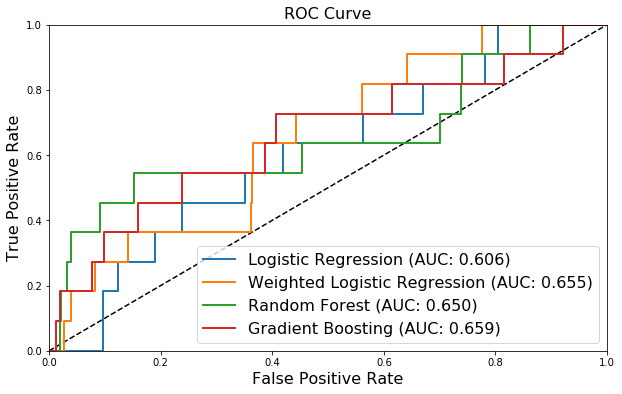

start printing ROC curve


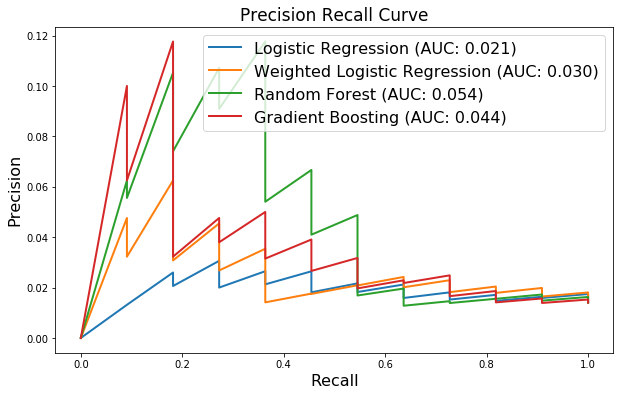

Best: 0.000000 using {'class_weight': {0: 100, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 100, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 10, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 1, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 1, 1: 10}}
0.000000 (0.000000) with: {'class_weight': {0: 1, 1: 100}}
rf-best params are
{'class_weight': 'balanced_subsample', 'max_depth': 6, 'max_features': 10}
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.1s finished


xgb-best params are
{'max_features': 9, 'max_depth': 11, 'class_weight': {0: 1.0, 1: 1000.0}}
start printing ROC curve


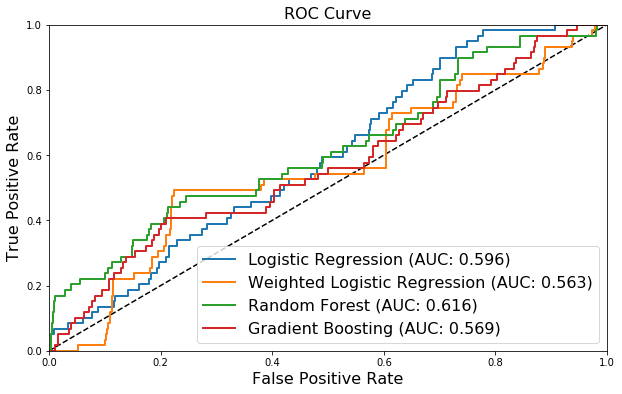

start printing ROC curve


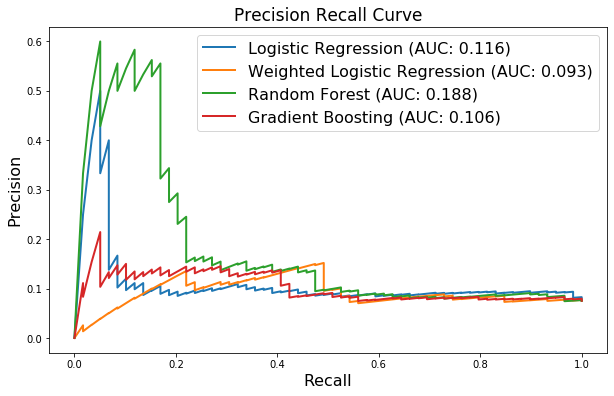

Best: 0.400000 using {'class_weight': {0: 1, 1: 100}}
0.000000 (0.000000) with: {'class_weight': {0: 100, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 10, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 1, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 1, 1: 10}}
0.400000 (0.489898) with: {'class_weight': {0: 1, 1: 100}}
rf-best params are
{'class_weight': 'balanced_subsample', 'max_depth': 6, 'max_features': 10}
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.4s finished


xgb-best params are
{'max_features': 9, 'max_depth': 11, 'class_weight': {0: 1.0, 1: 1000.0}}
start printing ROC curve


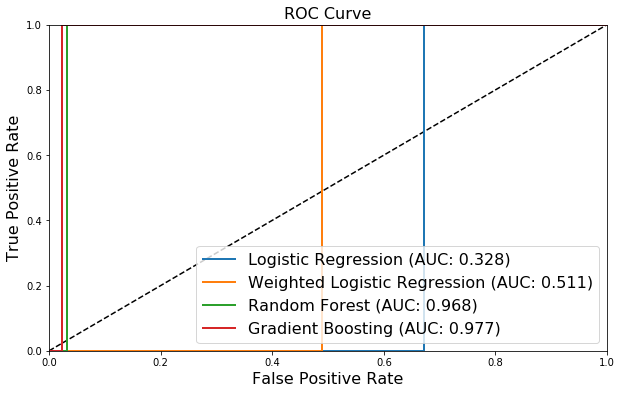

start printing ROC curve


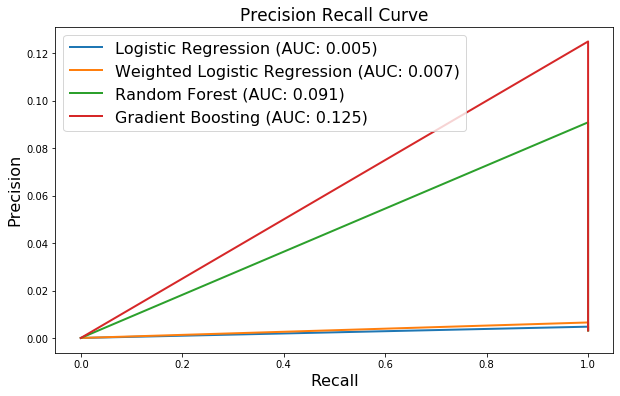

Best: 0.283333 using {'class_weight': {0: 1, 1: 100}}
0.000000 (0.000000) with: {'class_weight': {0: 100, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 10, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 1, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 1, 1: 10}}
0.283333 (0.401732) with: {'class_weight': {0: 1, 1: 100}}
rf-best params are
{'class_weight': {0: 1.0, 1: 1000.0}, 'max_depth': 6, 'max_features': 10}
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    3.0s finished


xgb-best params are
{'max_features': 9, 'max_depth': 11, 'class_weight': {0: 1.0, 1: 1000.0}}
start printing ROC curve


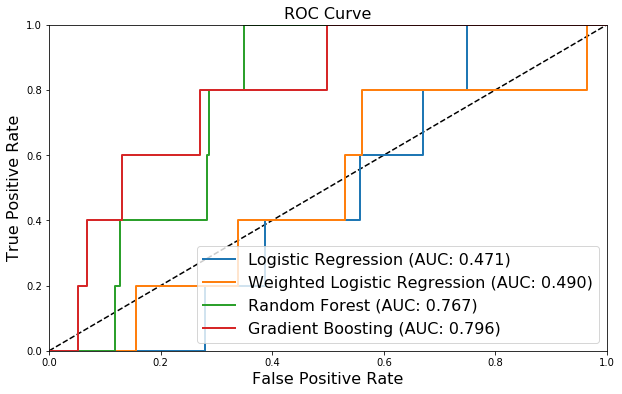

start printing ROC curve


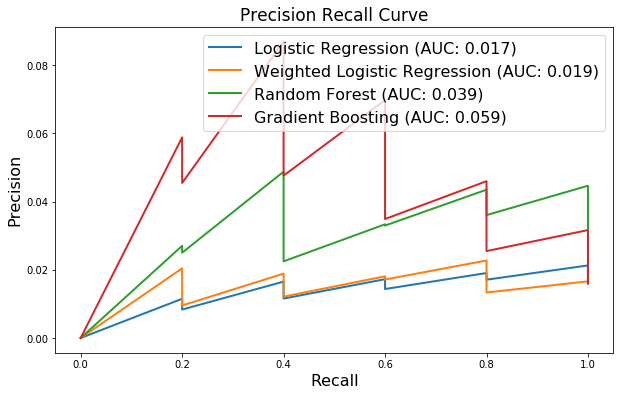

Best: 0.433333 using {'class_weight': {0: 1, 1: 100}}
0.000000 (0.000000) with: {'class_weight': {0: 100, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 10, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 1, 1: 1}}
0.300000 (0.458258) with: {'class_weight': {0: 1, 1: 10}}
0.433333 (0.495536) with: {'class_weight': {0: 1, 1: 100}}
rf-best params are
{'class_weight': {0: 1.0, 1: 1000.0}, 'max_depth': 9, 'max_features': 10}
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    0.6s finished


xgb-best params are
{'max_features': 9, 'max_depth': 11, 'class_weight': {0: 1.0, 1: 1000.0}}
start printing ROC curve


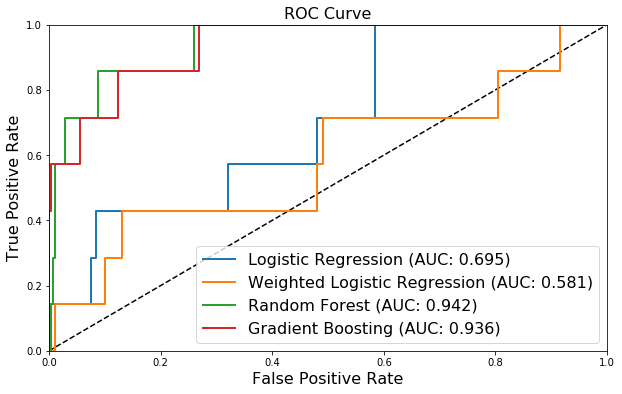

start printing ROC curve


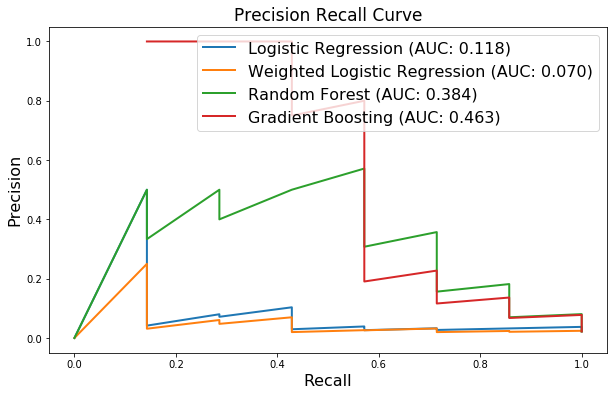

In [214]:
country_list = ["mw","tz","ug"]
measure_list = ["FCS","rCSI"]

for country in country_list:
    for measure in measure_list:
        if (measure=="rCSI") & (country=="ug"):
            pass
        else:
            if country=="mw":
                df = mw_village
            elif country == "ug":
                df = ug_village
            elif country == "tz":
                df = tz_village

            roc_lr,pr_lr,roc_lr_w,pr_lr_w,roc_rf,pr_rf,roc_xgb,pr_xgb = roc_pr_values(country,df,measure,cut='bad')
            ROC_curve_plot(roc_lr,roc_lr_w,roc_rf,roc_xgb)
            pr_curve_plot(pr_lr,pr_lr_w,pr_rf,pr_xgb)

#### ROC curve for the secure vs not"

Best: 1.000000 using {'class_weight': {0: 1, 1: 100}}
0.000000 (0.000000) with: {'class_weight': {0: 100, 1: 1}}
0.017706 (0.023889) with: {'class_weight': {0: 10, 1: 1}}
0.330502 (0.087335) with: {'class_weight': {0: 1, 1: 1}}
0.972581 (0.026914) with: {'class_weight': {0: 1, 1: 10}}
1.000000 (0.000000) with: {'class_weight': {0: 1, 1: 100}}
rf-best params are
{'class_weight': {0: 1.0, 1: 1000.0}, 'max_depth': 6, 'max_features': 10}
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    7.4s finished


xgb-best params are
{'max_features': 8, 'max_depth': 8, 'class_weight': 'balanced_subsample'}
start printing ROC curve


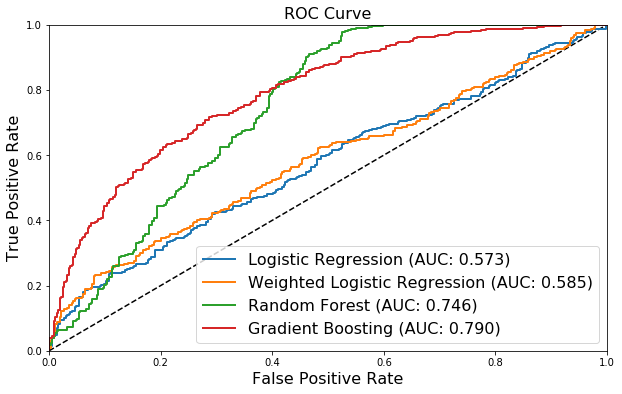

start printing ROC curve


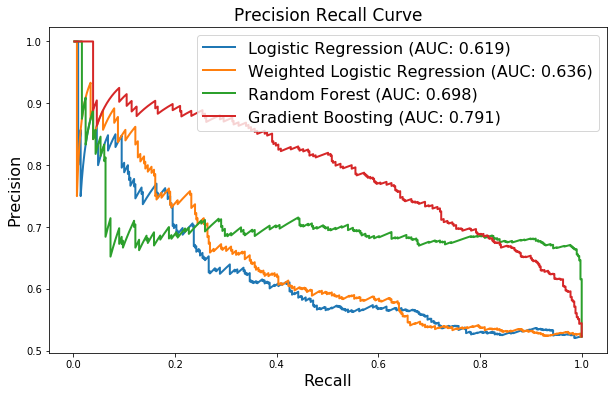

Best: 1.000000 using {'class_weight': {0: 1, 1: 100}}
0.021534 (0.031340) with: {'class_weight': {0: 100, 1: 1}}
0.098307 (0.043414) with: {'class_weight': {0: 10, 1: 1}}
0.470053 (0.070767) with: {'class_weight': {0: 1, 1: 1}}
0.970000 (0.030840) with: {'class_weight': {0: 1, 1: 10}}
1.000000 (0.000000) with: {'class_weight': {0: 1, 1: 100}}
rf-best params are
{'class_weight': {0: 1.0, 1: 100.0}, 'max_depth': 6, 'max_features': 10}
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    8.4s finished


xgb-best params are
{'max_features': 9, 'max_depth': 13, 'class_weight': {0: 1.0, 1: 1000.0}}
start printing ROC curve


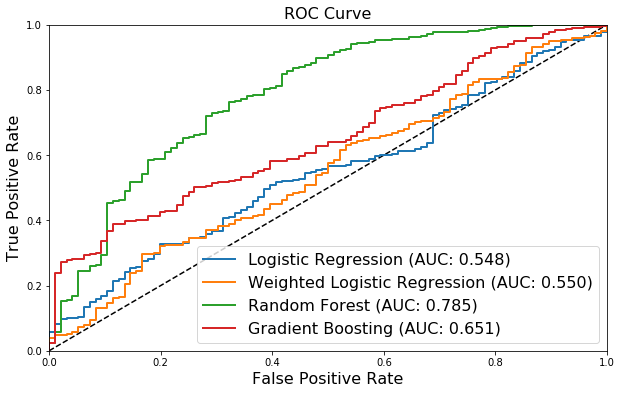

start printing ROC curve


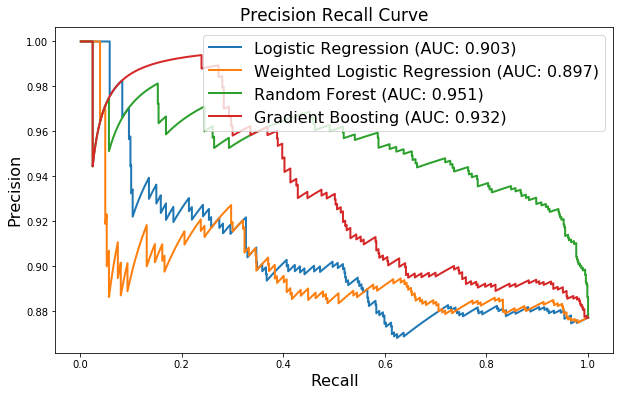

Best: 1.000000 using {'class_weight': {0: 1, 1: 100}}
0.000000 (0.000000) with: {'class_weight': {0: 100, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 10, 1: 1}}
0.098254 (0.069023) with: {'class_weight': {0: 1, 1: 1}}
0.929206 (0.081693) with: {'class_weight': {0: 1, 1: 10}}
1.000000 (0.000000) with: {'class_weight': {0: 1, 1: 100}}
rf-best params are
{'class_weight': {0: 1.0, 1: 100.0}, 'max_depth': 6, 'max_features': 12}
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    5.4s finished


xgb-best params are
{'max_features': 8, 'max_depth': 14, 'class_weight': 'balanced'}
start printing ROC curve


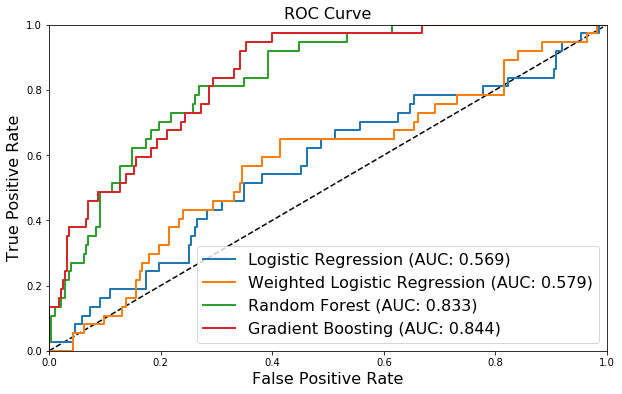

start printing ROC curve


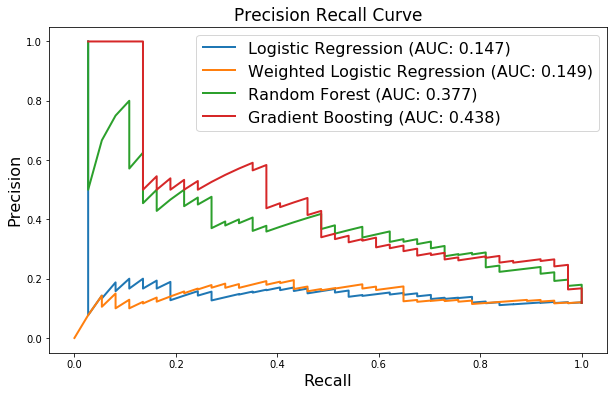

Best: 1.000000 using {'class_weight': {0: 1, 1: 100}}
0.000000 (0.000000) with: {'class_weight': {0: 100, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 10, 1: 1}}
0.318519 (0.090520) with: {'class_weight': {0: 1, 1: 1}}
0.996296 (0.011111) with: {'class_weight': {0: 1, 1: 10}}
1.000000 (0.000000) with: {'class_weight': {0: 1, 1: 100}}
rf-best params are
{'class_weight': {0: 1.0, 1: 100.0}, 'max_depth': 6, 'max_features': 10}
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    6.2s finished


xgb-best params are
{'max_features': 8, 'max_depth': 9, 'class_weight': 'balanced_subsample'}
start printing ROC curve


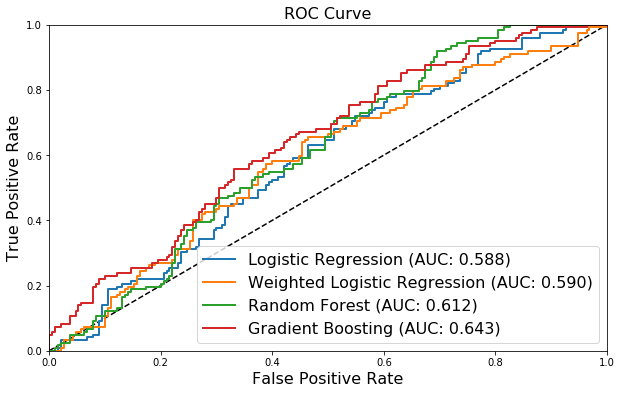

start printing ROC curve


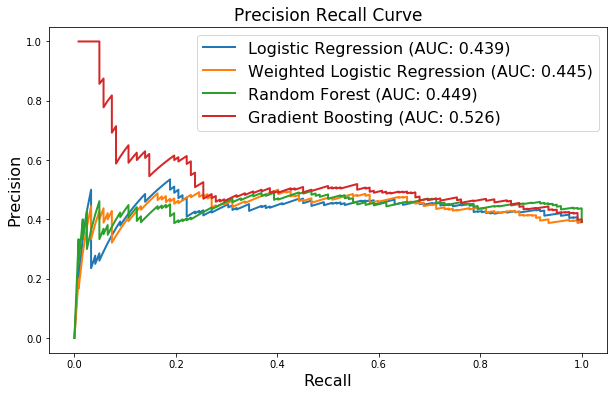

Best: 1.000000 using {'class_weight': {0: 1, 1: 100}}
0.000000 (0.000000) with: {'class_weight': {0: 100, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 10, 1: 1}}
0.290110 (0.140902) with: {'class_weight': {0: 1, 1: 1}}
0.989744 (0.026149) with: {'class_weight': {0: 1, 1: 10}}
1.000000 (0.000000) with: {'class_weight': {0: 1, 1: 100}}
rf-best params are
{'class_weight': {0: 1.0, 1: 100.0}, 'max_depth': 6, 'max_features': 11}
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    1.3s finished


xgb-best params are
{'max_features': 9, 'max_depth': 11, 'class_weight': {0: 1.0, 1: 1000.0}}
start printing ROC curve


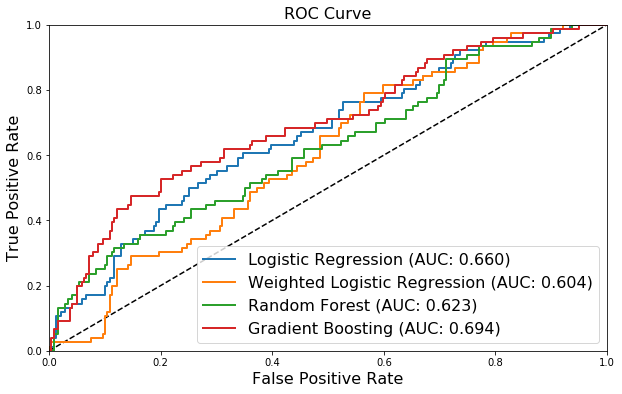

start printing ROC curve


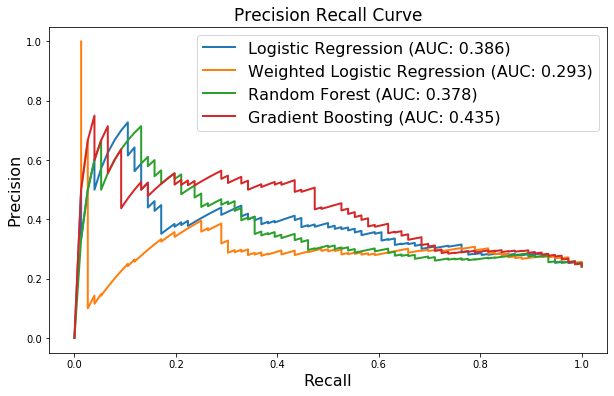

In [215]:
country_list = ["mw","tz","ug"]
measure_list = ["FCS","rCSI"]

for country in country_list:
    for measure in measure_list:
        if (measure=="rCSI") & (country=="ug"):
            pass
        else:
            if country=="mw":
                df = mw_village
            elif country == "ug":
                df = ug_village
            elif country == "tz":
                df = tz_village

            roc_lr,pr_lr,roc_lr_w,pr_lr_w,roc_rf,pr_rf,roc_xgb,pr_xgb = roc_pr_values(country,df,measure,cut='safe')
            ROC_curve_plot(roc_lr,roc_lr_w,roc_rf,roc_xgb)
            pr_curve_plot(pr_lr,pr_lr_w,pr_rf,pr_xgb)

### Oversample for inseure class

Combination of class weights, upsampling; Three figures: comparing baseline lr, weighted lr, rfc, upsampled rfc 

In [198]:
from sklearn.utils import resample
from imblearn.over_sampling import RandomOverSampler 
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import ADASYN

def upsample_minority(X_train,y_train):
    
    '''
    train_df = pd.concat([X_train, y_train[category]], axis=1)

    # separate minority and majority classes
    train_df_not_crisis = train_df[train_df[category]==0]
    train_df_crisis = train_df[train_df[category]==1]

    # upsample minority
    X_train_upsampled_minority = resample(train_df_crisis,replace=True, # sample with replacement
                                     n_samples=len(train_df_crisis), # match number in majority class
                                     random_state=27) # reproducible results
    
    # combine majority and upsampled minority
    X_train_upsampled = pd.concat([train_df_not_crisis,X_train_upsampled_minority])

    y_train_upsampled = X_train_upsampled[category]

    X_train_upsampled = X_train_upsampled.drop(category,axis=1)

     
    return X_train_upsampled,y_train_upsampled
    '''
    
    ros = RandomOverSampler(random_state=42,sampling_strategy='minority')
    X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)
    
        
    return X_train_ros, y_train_ros
   

def smote_minority(X_train,y_train):
    
    smt = SMOTETomek(random_state=42,sampling_strategy='minority')

    X_train_smote, y_train_smote = smt.fit_resample(X_train, y_train)

    # smt_non = SMOTETomek(random_state=42,sampling_strategy='not minority')
    
    return X_train_smote, y_train_smote 

def adasyn_minority(X_train,y_train):
    
    ada = ADASYN(random_state=42,n_jobs=5,sampling_strategy='minority')

    X_train_ada, y_train_ada = ada.fit_resample(X_train, y_train)
    
    return X_train_ada, y_train_ada 

 

def upsample_training_set(country,df,measure,cut):
      
    df_test,df_train = year_split(country, df)
    
    X_train,X_test,y_train_category,y_test_category,y_train_percent,y_test_percent = separate_y(country,df_test,df_train)
    
    category = measure+'_binary_'+cut
    
       
    '''
    if method == "upsample":
        # X_train_upsampled,y_train_upsampled = upsample_minority(X_train,y_train_category[category],category)
         X_train_upsampled,y_train_upsampled = upsample_minority(X_train,y_train_category[category])
    elif method == "smote":
        X_train_upsampled,y_train_upsampled = smote_minority(X_train,y_train_category[category])
    elif method == "adasyn":
        X_train_upsampled,y_train_upsampled = adasyn_minority(X_train,y_train_category[category])
    '''

    X_train_upsampled,y_train_upsampled = upsample_minority(X_train,y_train_category[category])

    
    try:
        X_train_smote,y_train_smote = smote_minority(X_train,y_train_category[category])
    except:
        X_train_upsampled,y_train_upsampled = upsample_minority(X_train,y_train_category[category])
        X_train_smote,y_train_smote = smote_minority(X_train_upsampled,y_train_upsampled)
    
    try:
        X_train_adasyn,y_train_adasyn = adasyn_minority(X_train,y_train_category[category])
    except:
        X_train_upsampled,y_train_upsampled = upsample_minority(X_train,y_train_category[category])
        X_train_adasyn,y_train_adasyn = adasyn_minority(X_train_upsampled,y_train_upsampled)

    
        
    y_test = y_test_category[category]
    y_train = y_train_category[category]
    
    return X_train,y_train,X_train_upsampled,y_train_upsampled, X_train_smote,y_train_smote,X_train_adasyn,y_train_adasyn,X_test,y_test
     
    
def roc_pr_values_upsample(X_train,y_train,X_train_upsampled,y_train_upsampled, X_train_smote,y_train_smote,X_train_adasyn,y_train_adasyn,X_test,y_test):
    
    # baseline
    y_prob,y_test  = lrCLF(X_train,y_train,X_test,y_test,prob=True)
    tpr_lr,fpr_lr,auc_roc_lr = get_roc(y_prob,y_test)  
    precision_lr,recall_lr,auc_pr_lr = get_pr(y_prob,y_test)
    
    # weighted lr 
    y_prob,y_test  = lr_weighted_CLF(X_train,y_train,X_test,y_test,prob=True)
    tpr_lr_w,fpr_lr_w,auc_roc_lr_w = get_roc(y_prob,y_test)  
    precision_lr_w,recall_lr_w,auc_pr_lr_w = get_pr(y_prob,y_test)
    
    # rfc baseline 
    y_prob,y_test  = rfCLF(X_train,y_train,X_test,y_test,prob=True)
    tpr_rfc,fpr_rfc,auc_roc_rfc = get_roc(y_prob,y_test)  
    precision_rfc,recall_rfc,auc_pr_rfc = get_pr(y_prob,y_test)
    
    # rfc_upsample
    y_prob,y_test  = rfCLF(X_train_upsampled,y_train_upsampled,X_test,y_test,prob=True)
    tpr_rfc_up,fpr_rfc_up,auc_roc_rfc_up = get_roc(y_prob,y_test)  
    precision_rfc_up,recall_rfc_up,auc_pr_rfc_up = get_pr(y_prob,y_test)
    
    # rfc smote
    y_prob,y_test  = rfCLF(X_train_smote,y_train_smote,X_test,y_test,prob=True)
    tpr_rfc_smote,fpr_rfc_smote,auc_roc_rfc_smote = get_roc(y_prob,y_test)  
    precision_rfc_smote,recall_rfc_smote,auc_pr_rfc_smote = get_pr(y_prob,y_test)
    
    # rfc adasyn
    y_prob,y_test  = rfCLF(X_train_adasyn,y_train_adasyn,X_test,y_test,prob=True)
    tpr_rfc_adasyn,fpr_rfc_adasyn,auc_roc_rfc_adasyn = get_roc(y_prob,y_test)  
    precision_rfc_adasyn,recall_rfc_adasyn,auc_pr_rfc_adasyn = get_pr(y_prob,y_test)
    
    roc_lr = [tpr_lr,fpr_lr,auc_roc_lr]
    pr_lr = [precision_lr,recall_lr,auc_pr_lr]
    
    roc_lr_w = [tpr_lr_w,fpr_lr_w,auc_roc_lr_w]
    pr_lr_w = [precision_lr_w,recall_lr_w,auc_pr_lr_w]
    
    roc_rfc = [tpr_rfc,fpr_rfc,auc_roc_rfc]
    pr_rfc = [precision_rfc,recall_rfc,auc_pr_rfc]
    
    roc_rfc_up = [tpr_rfc_up,fpr_rfc_up,auc_roc_rfc_up]
    pr_rfc_up = [precision_rfc_up,recall_rfc_up,auc_pr_rfc_up]
    
    roc_rfc_smote = [tpr_rfc_smote,fpr_rfc_smote,auc_roc_rfc_smote]
    pr_rfc_smote = [precision_rfc_smote,recall_rfc_smote,auc_pr_rfc_smote]
    
    roc_rfc_adasyn = [tpr_rfc_adasyn,fpr_rfc_adasyn,auc_roc_rfc_adasyn]
    pr_rfc_adasyn = [precision_rfc_adasyn,recall_rfc_adasyn,auc_pr_rfc_adasyn]
    

    return roc_lr,pr_lr,roc_lr_w,pr_lr_w,roc_rfc,pr_rfc,roc_rfc_up,pr_rfc_up,roc_rfc_smote,pr_rfc_smote,roc_rfc_adasyn,pr_rfc_adasyn
    
def roc_pr_values_upsample_xgb(X_train,y_train,X_train_upsampled,y_train_upsampled, X_train_smote,y_train_smote,X_train_adasyn,y_train_adasyn,X_test,y_test):
    
    # baseline
    y_prob,y_test  = lrCLF(X_train,y_train,X_test,y_test,prob=True)
    tpr_lr,fpr_lr,auc_roc_lr = get_roc(y_prob,y_test)  
    precision_lr,recall_lr,auc_pr_lr = get_pr(y_prob,y_test)
    
    # weighted lr 
    y_prob,y_test  = lr_weighted_CLF(X_train,y_train,X_test,y_test,prob=True)
    tpr_lr_w,fpr_lr_w,auc_roc_lr_w = get_roc(y_prob,y_test)  
    precision_lr_w,recall_lr_w,auc_pr_lr_w = get_pr(y_prob,y_test)
    
    # rfc baseline 
    y_prob,y_test  = rfCLF(X_train,y_train,X_test,y_test,prob=True)
    tpr_rfc,fpr_rfc,auc_roc_rfc = get_roc(y_prob,y_test)  
    precision_rfc,recall_rfc,auc_pr_rfc = get_pr(y_prob,y_test)
    
    # xgbc baseline 
    y_prob,y_test  = xgbCLF(X_train,y_train,X_test,y_test,prob=True)
    tpr_xgbc,fpr_xgbc,auc_roc_xgbc = get_roc(y_prob,y_test)  
    precision_xgbc,recall_xgbc,auc_pr_xgbc = get_pr(y_prob,y_test)
    
    # xgbc_upsample
    y_prob,y_test  = xgbCLF(X_train_upsampled,y_train_upsampled,X_test,y_test,prob=True)
    tpr_xgbc_up,fpr_xgbc_up,auc_roc_xgbc_up = get_roc(y_prob,y_test)  
    precision_xgbc_up,recall_xgbc_up,auc_pr_xgbc_up = get_pr(y_prob,y_test)
    
    # xgbc smote
    y_prob,y_test  = xgbCLF(X_train_smote,y_train_smote,X_test,y_test,prob=True)
    tpr_xgbc_smote,fpr_xgbc_smote,auc_roc_xgbc_smote = get_roc(y_prob,y_test)  
    precision_xgbc_smote,recall_xgbc_smote,auc_pr_xgbc_smote = get_pr(y_prob,y_test)
    
    # xgbc adasyn
    y_prob,y_test  = xgbCLF(X_train_adasyn,y_train_adasyn,X_test,y_test,prob=True)
    tpr_xgbc_adasyn,fpr_xgbc_adasyn,auc_roc_xgbc_adasyn = get_roc(y_prob,y_test)  
    precision_xgbc_adasyn,recall_xgbc_adasyn,auc_pr_xgbc_adasyn = get_pr(y_prob,y_test)
    
    roc_lr = [tpr_lr,fpr_lr,auc_roc_lr]
    pr_lr = [precision_lr,recall_lr,auc_pr_lr]
    
    roc_lr_w = [tpr_lr_w,fpr_lr_w,auc_roc_lr_w]
    pr_lr_w = [precision_lr_w,recall_lr_w,auc_pr_lr_w]
    
    roc_rfc = [tpr_rfc,fpr_rfc,auc_roc_rfc]
    pr_rfc = [precision_rfc,recall_rfc,auc_pr_rfc]
    
    roc_xgbc = [tpr_xgbc,fpr_xgbc,auc_roc_xgbc]
    pr_xgbc = [precision_xgbc,recall_xgbc,auc_pr_xgbc]
    
    roc_xgbc_up = [tpr_xgbc_up,fpr_xgbc_up,auc_roc_xgbc_up]
    pr_xgbc_up = [precision_xgbc_up,recall_xgbc_up,auc_pr_xgbc_up]
    
    roc_xgbc_smote = [tpr_xgbc_smote,fpr_xgbc_smote,auc_roc_xgbc_smote]
    pr_xgbc_smote = [precision_xgbc_smote,recall_xgbc_smote,auc_pr_xgbc_smote]
    
    roc_xgbc_adasyn = [tpr_xgbc_adasyn,fpr_xgbc_adasyn,auc_roc_xgbc_adasyn]
    pr_xgbc_adasyn = [precision_xgbc_adasyn,recall_xgbc_adasyn,auc_pr_xgbc_adasyn]
    

    return roc_lr,pr_lr,roc_lr_w,pr_lr_w,roc_rfc,pr_rfc,roc_xgbc,pr_xgbc,roc_xgbc_up,pr_xgbc_up,roc_xgbc_smote,pr_xgbc_smote,roc_xgbc_adasyn,pr_xgbc_adasyn
    

def ROC_curve_up_plot(roc_lr,roc_lr_w,roc_rfc,roc_xgbc, roc_xgbc_up,roc_xgbc_smote,roc_xgbc_adasyn):
    '''
    roc curve plotting
    '''
    
    print("start printing ROC curve")
    
    
    fpr_lr,tpr_lr,auc_lr = roc_lr
    fpr_lr_w,tpr_lr_w,auc_lr_w = roc_lr_w
    fpr_rfc,tpr_rfc,auc_rfc = roc_rfc
    fpr_xgbc,tpr_xgbc,auc_xgbc = roc_xgbc
    fpr_xgbc_up,tpr_xgbc_up,auc_xgbc_up = roc_xgbc_up
    fpr_xgbc_smote,tpr_xgbc_smote,auc_xgbc_smote = roc_xgbc_smote
    fpr_xgbc_adasyn,tpr_xgbc_adasyn,auc_xgbc_adasyn = roc_xgbc_adasyn

    
    # ROC curve 
    plt.figure(figsize=(10,6))
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.plot(fpr_lr,tpr_lr,label="Logistic Regression (AUC: {:.3f})".format(auc_lr),linewidth=2)
    plt.plot(fpr_lr_w,tpr_lr_w,label="weighted Logistic Regression (AUC: {:.3f})".format(auc_lr_w),linewidth=2)
    plt.plot(fpr_rfc,tpr_rfc,label="Random Forest (AUC: {:.3f})".format(auc_rfc),linewidth=2)
    plt.plot(fpr_xgbc,tpr_xgbc,label="Gradient Boosting (AUC: {:.3f})".format(auc_xgbc),linewidth=2)
    plt.plot(fpr_xgbc_up,tpr_xgbc_up,label="UPSAMPLE Gradient Boosting (AUC: {:.3f})".format(auc_xgbc_up),linewidth=2)
    plt.plot(fpr_xgbc_smote,tpr_xgbc_smote,label="SMOTE Gradient Boosting (AUC: {:.3f})".format(auc_xgbc_smote),linewidth=2)
    plt.plot(fpr_xgbc_adasyn,tpr_xgbc_adasyn,label="ADASYN Gradient Boosting (AUC: {:.3f})".format(auc_xgbc_adasyn),linewidth=2)
    
    plt.xlabel("False Positive Rate",fontsize=16)
    plt.ylabel("True Positive Rate",fontsize=16)
    plt.title("ROC Curve",fontsize=16)
    plt.legend(loc="lower right",fontsize=16) 
    
     
    return plt.show()
    
def pr_curve_up_plot(pr_lr,pr_lr_w,pr_rfc, pr_xgbc,pr_xgbc_up,pr_xgbc_smote,pr_xgbc_adasyn):
    '''
    pr curve plotting
    '''
    
    print("start printing PR curve")
    
    precision_lr,recall_lr,auc_pr_lr = pr_lr
    precision_lr_w,recall_lr_w,auc_pr_lr_w = pr_lr_w
    precision_rfc,recall_rfc,auc_pr_rfc = pr_rfc
    precision_xgbc,recall_xgbc,auc_pr_xgbc = pr_xgbc
    precision_xgbc_up,recall_xgbc_up,auc_pr_xgbc_up = pr_xgbc_up
    precision_xgbc_smote,recall_xgbc_smote,auc_pr_xgbc_smote = pr_xgbc_smote
    precision_xgbc_adasyn,recall_xgbc_adasyn,auc_pr_xgbc_adasyn = pr_xgbc_adasyn

    
    # PR CURVE 
    plt.figure(figsize=(10,6))
    plt.plot(recall_lr,precision_lr,label="Logistic Regression (AUC: {:.3f})".format(auc_pr_lr),linewidth=2)
    plt.plot(recall_lr_w,precision_lr_w,label="weighted Logistic Regression (AUC: {:.3f})".format(auc_pr_lr_w),linewidth=2)
    plt.plot(recall_rfc,precision_rfc,label="Random Forest (AUC: {:.3f})".format(auc_pr_rfc),linewidth=2)
    plt.plot(recall_xgbc,precision_xgbc,label="Gradient Boosting(AUC: {:.3f})".format(auc_pr_xgbc),linewidth=2)
    plt.plot(recall_xgbc_up,precision_xgbc_up,label="UPSAMPLE Gradient Boosting (AUC: {:.3f})".format(auc_pr_xgbc_up),linewidth=2)
    plt.plot(recall_xgbc_smote,precision_xgbc_smote,label="SMOTE Gradient Boosting (AUC: {:.3f})".format(auc_pr_xgbc_smote),linewidth=2)
    plt.plot(recall_xgbc_adasyn,precision_xgbc_adasyn,label="ADASYN Gradient Boosting (AUC: {:.3f})".format(auc_pr_xgbc_adasyn),linewidth=2)

    plt.xlabel("Recall",fontsize=16)
    plt.ylabel("Precision",fontsize=16)
    plt.title("Precision Recall Curve",fontsize=17)
    plt.legend(fontsize=16)
    
 
    
    return plt.show()




Best: 0.333333 using {'class_weight': {0: 1, 1: 100}}
0.000000 (0.000000) with: {'class_weight': {0: 100, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 10, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 1, 1: 1}}
0.166667 (0.372678) with: {'class_weight': {0: 1, 1: 10}}
0.333333 (0.471405) with: {'class_weight': {0: 1, 1: 100}}
rf-best params are
{'class_weight': 'balanced_subsample', 'max_depth': 6, 'max_features': 10}
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    4.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


xgb-best params are
{'max_features': 9, 'max_depth': 11, 'class_weight': {0: 1.0, 1: 1000.0}}
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    7.7s finished


xgb-best params are
{'max_features': 9, 'max_depth': 11, 'class_weight': {0: 1.0, 1: 1000.0}}
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   10.0s finished


xgb-best params are
{'max_features': 9, 'max_depth': 11, 'class_weight': {0: 1.0, 1: 1000.0}}
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   10.0s finished


xgb-best params are
{'max_features': 8, 'max_depth': 9, 'class_weight': 'balanced_subsample'}
start printing ROC curve


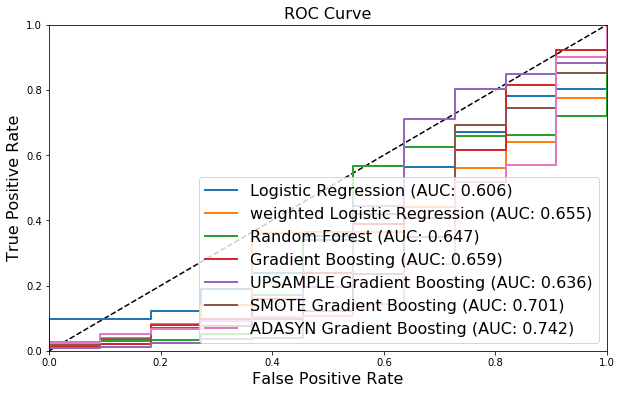

start printing PR curve


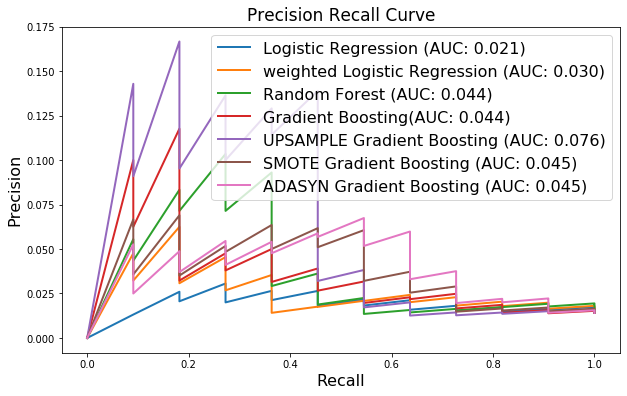

Best: 0.000000 using {'class_weight': {0: 100, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 100, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 10, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 1, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 1, 1: 10}}
0.000000 (0.000000) with: {'class_weight': {0: 1, 1: 100}}
rf-best params are
{'class_weight': 'balanced_subsample', 'max_depth': 6, 'max_features': 10}
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


xgb-best params are
{'max_features': 9, 'max_depth': 11, 'class_weight': {0: 1.0, 1: 1000.0}}
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    5.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


xgb-best params are
{'max_features': 9, 'max_depth': 11, 'class_weight': {0: 1.0, 1: 1000.0}}
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    5.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


xgb-best params are
{'max_features': 9, 'max_depth': 11, 'class_weight': {0: 1.0, 1: 1000.0}}
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    5.4s finished


xgb-best params are
{'max_features': 9, 'max_depth': 11, 'class_weight': {0: 1.0, 1: 1000.0}}
start printing ROC curve


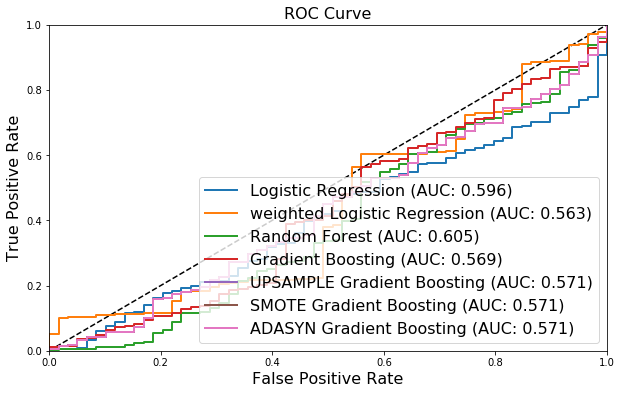

start printing PR curve


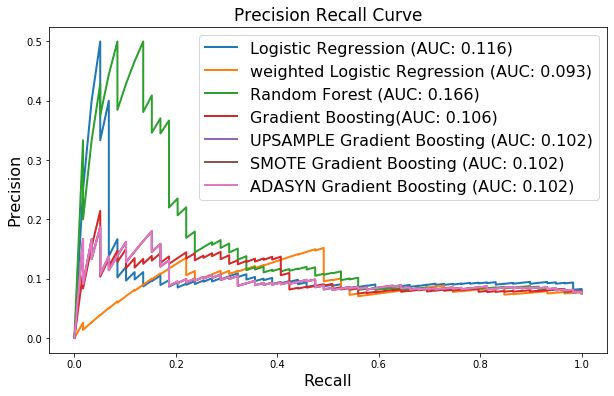

Best: 0.400000 using {'class_weight': {0: 1, 1: 100}}
0.000000 (0.000000) with: {'class_weight': {0: 100, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 10, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 1, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 1, 1: 10}}
0.400000 (0.489898) with: {'class_weight': {0: 1, 1: 100}}
rf-best params are
{'class_weight': 'balanced_subsample', 'max_depth': 6, 'max_features': 10}
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


xgb-best params are
{'max_features': 9, 'max_depth': 11, 'class_weight': {0: 1.0, 1: 1000.0}}
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    5.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


xgb-best params are
{'max_features': 9, 'max_depth': 11, 'class_weight': {0: 1.0, 1: 1000.0}}
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    6.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


xgb-best params are
{'max_features': 8, 'max_depth': 8, 'class_weight': 'balanced_subsample'}
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    7.0s finished


xgb-best params are
{'max_features': 9, 'max_depth': 11, 'class_weight': {0: 1.0, 1: 1000.0}}
start printing ROC curve


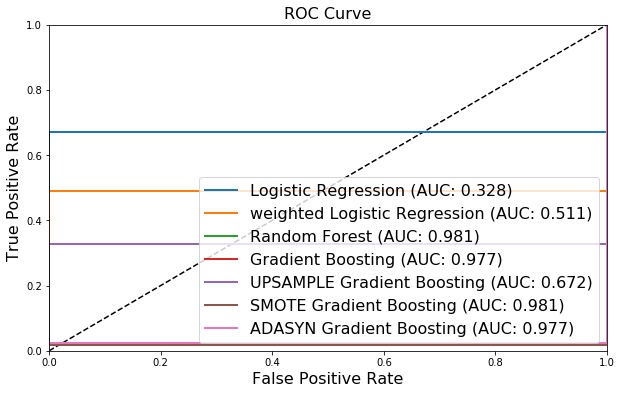

start printing PR curve


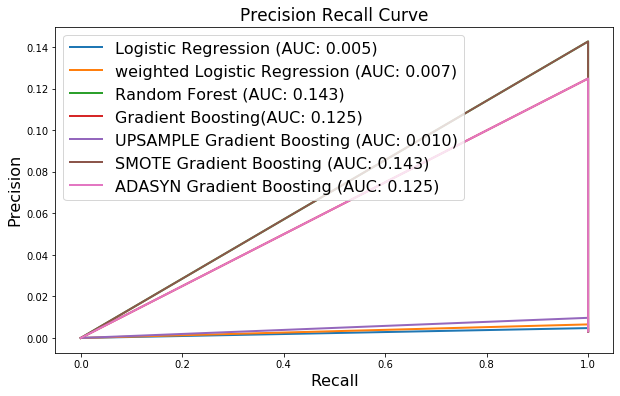

Best: 0.283333 using {'class_weight': {0: 1, 1: 100}}
0.000000 (0.000000) with: {'class_weight': {0: 100, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 10, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 1, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 1, 1: 10}}
0.283333 (0.401732) with: {'class_weight': {0: 1, 1: 100}}
rf-best params are
{'class_weight': 'balanced_subsample', 'max_depth': 6, 'max_features': 12}
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    3.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


xgb-best params are
{'max_features': 9, 'max_depth': 11, 'class_weight': {0: 1.0, 1: 1000.0}}
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    6.7s finished


xgb-best params are
{'max_features': 9, 'max_depth': 11, 'class_weight': {0: 1.0, 1: 1000.0}}
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    8.0s finished


xgb-best params are
{'max_features': 9, 'max_depth': 13, 'class_weight': {0: 1.0, 1: 1000.0}}
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    8.1s finished


xgb-best params are
{'max_features': 8, 'max_depth': 9, 'class_weight': 'balanced_subsample'}
start printing ROC curve


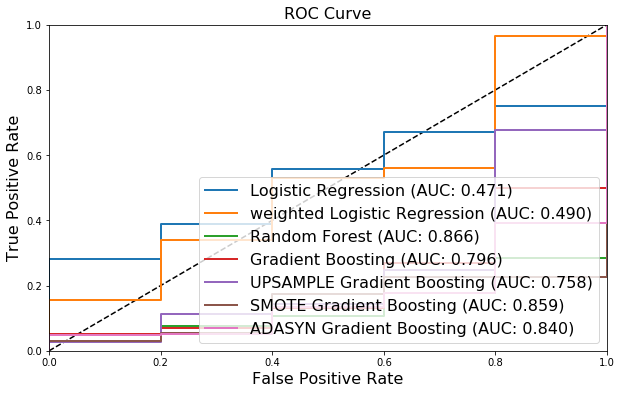

start printing PR curve


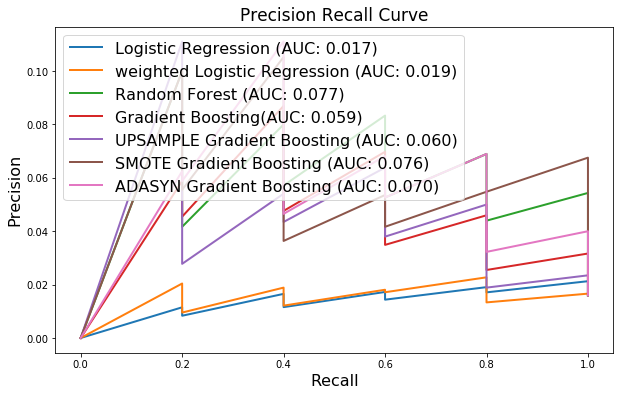

Best: 0.433333 using {'class_weight': {0: 1, 1: 100}}
0.000000 (0.000000) with: {'class_weight': {0: 100, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 10, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 1, 1: 1}}
0.300000 (0.458258) with: {'class_weight': {0: 1, 1: 10}}
0.433333 (0.495536) with: {'class_weight': {0: 1, 1: 100}}
rf-best params are
{'class_weight': {0: 1.0, 1: 100.0}, 'max_depth': 7, 'max_features': 11}
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


xgb-best params are
{'max_features': 9, 'max_depth': 11, 'class_weight': {0: 1.0, 1: 1000.0}}
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


xgb-best params are
{'max_features': 9, 'max_depth': 11, 'class_weight': {0: 1.0, 1: 1000.0}}
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


xgb-best params are
{'max_features': 9, 'max_depth': 11, 'class_weight': {0: 1.0, 1: 1000.0}}
Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    1.6s finished


xgb-best params are
{'max_features': 9, 'max_depth': 11, 'class_weight': {0: 1.0, 1: 1000.0}}
start printing ROC curve


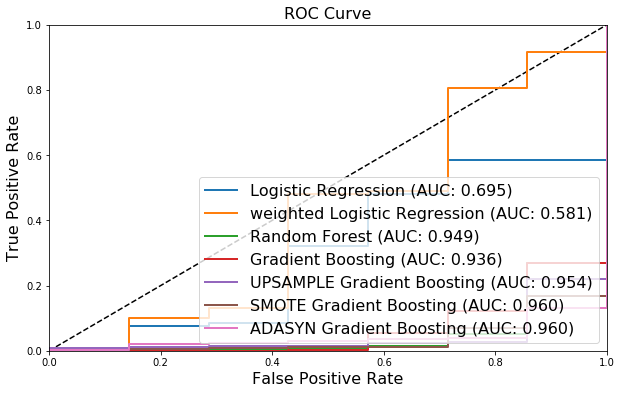

start printing PR curve


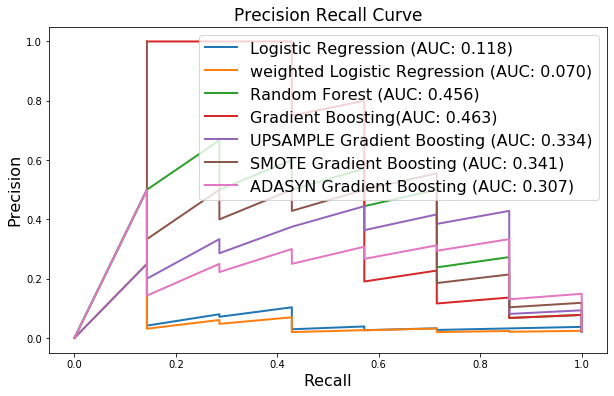

In [199]:
country_list = ["mw","tz","ug"]
measure_list = ["FCS","rCSI"]

for country in country_list:
    for measure in measure_list:
        if (measure=="rCSI") & (country=="ug"):
            pass
        else:
            if country=="mw":
                df = mw_village
            elif country == "ug":
                df = ug_village
            elif country == "tz":
                df = tz_village
            
            X_train,y_train,X_train_upsampled,y_train_upsampled, X_train_smote,y_train_smote,X_train_adasyn,y_train_adasyn,X_test,y_test = upsample_training_set(country,df,measure,cut='bad')
            roc_lr,pr_lr,roc_lr_w,pr_lr_w,roc_rfc,pr_rfc,roc_xgbc,pr_xgbc,roc_xgbc_up,pr_xgbc_up,roc_xgbc_smote,pr_xgbc_smote,roc_xgbc_adasyn,pr_xgbc_adasyn = roc_pr_values_upsample_xgb(X_train,y_train,X_train_upsampled,y_train_upsampled, X_train_smote,y_train_smote,X_train_adasyn,y_train_adasyn,X_test,y_test)
            ROC_curve_up_plot(roc_lr,roc_lr_w,roc_rfc,roc_xgbc, roc_xgbc_up,roc_xgbc_smote,roc_xgbc_adasyn)
            pr_curve_up_plot(pr_lr,pr_lr_w,pr_rfc, pr_xgbc,pr_xgbc_up,pr_xgbc_smote,pr_xgbc_adasyn)

            

In [196]:
country_list = ["mw","tz","ug"]
measure_list = ["FCS","rCSI"]

for country in country_list:
    for measure in measure_list:
        if (measure=="rCSI") & (country=="ug"):
            pass
        else:
            if country=="mw":
                df = mw_village
            elif country == "ug":
                df = ug_village
            elif country == "tz":
                df = tz_village
            
            X_train,y_train,X_train_upsampled,y_train_upsampled, X_train_smote,y_train_smote,X_train_adasyn,y_train_adasyn,X_test,y_test = upsample_training_set(country,df,measure,cut='bad')
            roc_lr,pr_lr,roc_lr_w,pr_lr_w,roc_rfc,pr_rfc,roc_rfc_up,pr_rfc_up,roc_rfc_smote,pr_rfc_smote,roc_rfc_adasyn,pr_rfc_adasyn = roc_pr_values_upsample(X_train,y_train,X_train_upsampled,y_train_upsampled, X_train_smote,y_train_smote,X_train_adasyn,y_train_adasyn,X_test,y_test)
            ROC_curve_up_plot(roc_lr,roc_lr_w,roc_rfc,roc_rfc_up,roc_rfc_smote,roc_rfc_adasyn)
            pr_curve_up_plot(pr_lr,pr_lr_w,pr_rfc,pr_rfc_up,pr_rfc_smote,pr_rfc_adasyn)

            

Best: 0.333333 using {'class_weight': {0: 1, 1: 100}}
0.000000 (0.000000) with: {'class_weight': {0: 100, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 10, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 1, 1: 1}}
0.166667 (0.372678) with: {'class_weight': {0: 1, 1: 10}}
0.333333 (0.471405) with: {'class_weight': {0: 1, 1: 100}}


KeyboardInterrupt: 

In [322]:
def classify_threshold_upsample(X_train,y_train,X_train_upsampled,y_train_upsampled, X_train_smote,y_train_smote,X_train_adasyn,y_train_adasyn,X_test,y_test,threshold):

    class_names = ['majority_class','minority_class']

    # baseline
    y_prob,y_test  = lrCLF(X_train,y_train,X_test,y_test,prob=True)
    y_pred = np.where(y_prob>= threshold,1,0)

    print ("----------------base model---------------- \n",
           classification_report(y_test, y_pred, target_names = class_names),'\n'  )
        
        
    # weighted lr 
    y_prob,y_test  = lr_weighted_CLF(X_train,y_train,X_test,y_test,prob=True)
    y_pred = np.where(y_prob>= threshold,1,0)
    
    print ("----------------weighted lr model---------------- \n",
           classification_report(y_test, y_pred, target_names = class_names),'\n'  )
        
    
    # rfc baseline 
    y_prob,y_test  = rfCLF(X_train,y_train,X_test,y_test,prob=True)
    y_pred = np.where(y_prob>= threshold,1,0)
    
    print ("----------------rfc model---------------- \n",
           classification_report(y_test, y_pred, target_names = class_names),'\n'  )
   


    # xgbc baseline 
    y_prob,y_test  = rfCLF(X_train,y_train,X_test,y_test,prob=True)
    y_pred = np.where(y_prob>= threshold,1,0)
    
    print ("----------------xgb model baseline---------------- \n",
           classification_report(y_test, y_pred, target_names = class_names),'\n'  )
   
    
    # xgbc_upsample
    y_prob,y_test  = rfCLF(X_train_upsampled,y_train_upsampled,X_test,y_test,prob=True)
    y_pred = np.where(y_prob>= threshold,1,0)
    
    print ("----------------xgb model upsample---------------- \n",
           classification_report(y_test, y_pred, target_names = class_names),'\n'  )
    
    # xgbc smote
    y_prob,y_test  = rfCLF(X_train_smote,y_train_smote,X_test,y_test,prob=True)
    y_pred = np.where(y_prob>= threshold,1,0)
    
    print ("----------------xgb model smote---------------- \n",
           classification_report(y_test, y_pred, target_names = class_names),'\n'  )
    
    
    # xgbc adasyn
    y_prob,y_test  = rfCLF(X_train_adasyn,y_train_adasyn,X_test,y_test,prob=True)
    y_pred = np.where(y_prob>= threshold,1,0)
    
    print ("----------------xgb model adasyn---------------- \n",
           classification_report(y_test, y_pred, target_names = class_names),'\n'  )
    

### Threshold table with upsample

In [386]:
from sklearn.metrics import confusion_matrix

X_train,y_train,X_train_upsampled,y_train_upsampled, X_train_smote,y_train_smote,X_train_adasyn,y_train_adasyn,X_test,y_test = upsample_training_set("mw",mw_village,"FCS",cut='bad')
threshold=0.01
class_names = ['majority','minority']

y_prob,y_test  = rfCLF(X_train_adasyn,y_train_adasyn,X_test,y_test,prob=True)
y_pred = np.where(y_prob>= threshold,1,0)

print ("----------------xgb model adasyn---------------- \n",
           classification_report(y_test, y_pred, target_names = class_names),'\n'  )

print(confusion_matrix(y_test, y_pred))

change = y_test-y_pred

print("Percent of False Negatives", '\n')
print(round(len(change.index[np.where(change == 1)])/len(change)*100,2))

print("Percent of False Positive ", '\n')
print(round(len(change.index[np.where(change == -1)])/len(change)*100,2))

print("average magnitude of false negatives ", '\n')
print(round(mean(28 - mw_village['FCS'][change.index[np.where(change == 1)]])/28 *100,2))


print( "average magnitude of false positives " , '\n')
print(round(mean(28 - mw_village['FCS'][change.index[np.where(change == -1)]])/28 *100,2))


rf-best params are
{'class_weight': {0: 1.0, 1: 100.0}, 'max_depth': 6, 'max_features': 11}
----------------xgb model adasyn---------------- 
               precision    recall  f1-score   support

    majority       1.00      0.45      0.62       771
    minority       0.02      0.91      0.04        11

    accuracy                           0.45       782
   macro avg       0.51      0.68      0.33       782
weighted avg       0.98      0.45      0.61       782
 

[[344 427]
 [  1  10]]
Percent of False Negatives 

0.13
Percent of False Positive  

54.6
average magnitude of false negatives  

6.47
average magnitude of false positives  

-42.67


In [390]:
from sklearn.metrics import confusion_matrix

X_train,y_train,X_train_upsampled,y_train_upsampled, X_train_smote,y_train_smote,X_train_adasyn,y_train_adasyn,X_test,y_test = upsample_training_set("tz",tz_village,"FCS",cut='bad')
threshold=0.01
class_names = ['majority','minority']

y_prob,y_test  = xgbCLF(X_train_adasyn,y_train_adasyn,X_test,y_test,prob=True)
y_pred = np.where(y_prob>= threshold,1,0)

print ("----------------xgb model adasyn---------------- \n",
           classification_report(y_test, y_pred, target_names = class_names),'\n'  )

print(confusion_matrix(y_test, y_pred))

change = y_test-y_pred

print("Percent of False Negatives", '\n')
print(round(len(change.index[np.where(change == 1)])/len(change)*100,2))

print("Percent of False Positive ", '\n')
print(round(len(change.index[np.where(change == -1)])/len(change)*100,2))

print("average magnitude of false negatives ", '\n')
print(round(mean(28 - tz_village['FCS'][change.index[np.where(change == 1)]])/28 *100,2))


print( "average magnitude of false positives " , '\n')
print(round(mean(28 - tz_village['FCS'][change.index[np.where(change == -1)]])/28 *100,2))


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    9.1s finished


xgb-best params are
{'max_features': 4, 'max_depth': 5, 'class_weight': 'balanced'}
----------------xgb model adasyn---------------- 
               precision    recall  f1-score   support

    majority       1.00      0.79      0.88       311
    minority       0.01      1.00      0.03         1

    accuracy                           0.79       312
   macro avg       0.51      0.89      0.46       312
weighted avg       1.00      0.79      0.88       312
 

[[245  66]
 [  0   1]]
Percent of False Negatives 

0.0
Percent of False Positive  

21.15
average magnitude of false negatives  

nan
average magnitude of false positives  

-86.21


In [388]:
from sklearn.metrics import confusion_matrix

X_train,y_train,X_train_upsampled,y_train_upsampled, X_train_smote,y_train_smote,X_train_adasyn,y_train_adasyn,X_test,y_test = upsample_training_set("ug",ug_village,"FCS",cut='bad')
threshold=0.01
class_names = ['majority','minority']

y_prob,y_test  = rfCLF(X_train_adasyn,y_train_adasyn,X_test,y_test,prob=True)
y_pred = np.where(y_prob>= threshold,1,0)

print ("----------------xgb model adasyn---------------- \n",
           classification_report(y_test, y_pred, target_names = class_names),'\n'  )

print(confusion_matrix(y_test, y_pred))

change = y_test-y_pred

print("Percent of False Negatives", '\n')
print(round(len(change.index[np.where(change == 1)])/len(change)*100,2))

print("Percent of False Positive ", '\n')
print(round(len(change.index[np.where(change == -1)])/len(change)*100,2))

print("average magnitude of false negatives ", '\n')
print(round(mean(28 - ug_village['FCS'][change.index[np.where(change == 1)]])/28 *100,2))


print( "average magnitude of false positives " , '\n')
print(round(mean(28 - ug_village['FCS'][change.index[np.where(change == -1)]])/28 *100,2))


rf-best params are
{'class_weight': {0: 1.0, 1: 100.0}, 'max_depth': 6, 'max_features': 10}
----------------xgb model adasyn---------------- 
               precision    recall  f1-score   support

    majority       1.00      0.52      0.68       308
    minority       0.04      1.00      0.09         7

    accuracy                           0.53       315
   macro avg       0.52      0.76      0.38       315
weighted avg       0.98      0.53      0.67       315
 

[[159 149]
 [  0   7]]
Percent of False Negatives 

0.0
Percent of False Positive  

47.3
average magnitude of false negatives  

nan
average magnitude of false positives  

-66.56


In [391]:
from sklearn.metrics import confusion_matrix

X_train,y_train,X_train_upsampled,y_train_upsampled, X_train_smote,y_train_smote,X_train_adasyn,y_train_adasyn,X_test,y_test = upsample_training_set("tz",tz_village,"rCSI",cut='bad')
threshold=0.01
class_names = ['majority','minority']

y_prob,y_test  = xgbCLF(X_train_adasyn,y_train_adasyn,X_test,y_test,prob=True)
y_pred = np.where(y_prob>= threshold,1,0)

print ("----------------xgb model adasyn---------------- \n",
           classification_report(y_test, y_pred, target_names = class_names),'\n'  )

print(confusion_matrix(y_test, y_pred))

change = y_test-y_pred

print("Percent of False Negatives", '\n')
print(round(len(change.index[np.where(change == 1)])/len(change)*100,2))

print("Percent of False Positive ", '\n')
print(round(len(change.index[np.where(change == -1)])/len(change)*100,2))

print("average magnitude of false negatives ", '\n')
print(round(mean(28 - tz_village['rCSI'][change.index[np.where(change == 1)]])/28 *100,2))


print( "average magnitude of false positives " , '\n')
print(round(mean(28 - tz_village['rCSI'][change.index[np.where(change == -1)]])/28 *100,2))


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    9.3s finished


xgb-best params are
{'max_features': 4, 'max_depth': 5, 'class_weight': 'balanced'}
----------------xgb model adasyn---------------- 
               precision    recall  f1-score   support

    majority       1.00      0.79      0.88       307
    minority       0.06      0.80      0.11         5

    accuracy                           0.79       312
   macro avg       0.53      0.80      0.50       312
weighted avg       0.98      0.79      0.87       312
 

[[243  64]
 [  1   4]]
Percent of False Negatives 

0.32
Percent of False Positive  

20.51
average magnitude of false negatives  

33.04
average magnitude of false positives  

77.41


In [392]:
from sklearn.metrics import confusion_matrix

X_train,y_train,X_train_upsampled,y_train_upsampled, X_train_smote,y_train_smote,X_train_adasyn,y_train_adasyn,X_test,y_test = upsample_training_set("mw",mw_village,"rCSI",cut='bad')
threshold=0.01
class_names = ['majority','minority']

y_prob,y_test  = xgbCLF(X_train_adasyn,y_train_adasyn,X_test,y_test,prob=True)
y_pred = np.where(y_prob>= threshold,1,0)

print ("----------------xgb model adasyn---------------- \n",
           classification_report(y_test, y_pred, target_names = class_names),'\n'  )

print(confusion_matrix(y_test, y_pred))

change = y_test-y_pred

print("Percent of False Negatives", '\n')
print(round(len(change.index[np.where(change == 1)])/len(change)*100,2))

print("Percent of False Positive ", '\n')
print(round(len(change.index[np.where(change == -1)])/len(change)*100,2))

print("average magnitude of false negatives ", '\n')
print(round(mean(28 - mw_village['rCSI'][change.index[np.where(change == 1)]])/28 *100,2))


print( "average magnitude of false positives " , '\n')
print(round(mean(28 - mw_village['rCSI'][change.index[np.where(change == -1)]])/28 *100,2))


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    6.7s finished


xgb-best params are
{'max_features': 6, 'max_depth': 10, 'class_weight': 'balanced'}
----------------xgb model adasyn---------------- 
               precision    recall  f1-score   support

    majority       0.93      0.95      0.94       723
    minority       0.12      0.08      0.10        59

    accuracy                           0.88       782
   macro avg       0.52      0.52      0.52       782
weighted avg       0.87      0.88      0.87       782
 

[[686  37]
 [ 54   5]]
Percent of False Negatives 

6.91
Percent of False Positive  

4.73
average magnitude of false negatives  

27.13
average magnitude of false positives  

69.72


In [ ]:
from sklearn.metrics import confusion_matrix

X_train,y_train,X_train_upsampled,y_train_upsampled, X_train_smote,y_train_smote,X_train_adasyn,y_train_adasyn,X_test,y_test = upsample_training_set("mw",mw_village,"FCS",cut='bad')
threshold=0.01
class_names = ['majority','minority']

y_prob,y_test  = rfCLF(X_train_adasyn,y_train_adasyn,X_test,y_test,prob=True)
y_pred = np.where(y_prob>= threshold,1,0)

print ("----------------xgb model adasyn---------------- \n",
           classification_report(y_test, y_pred, target_names = class_names),'\n'  )

print(confusion_matrix(y_test, y_pred))


In [323]:
X_train,y_train,X_train_upsampled,y_train_upsampled, X_train_smote,y_train_smote,X_train_adasyn,y_train_adasyn,X_test,y_test = upsample_training_set("mw",mw_village,"FCS",cut='bad')
classify_threshold_upsample(X_train,y_train,X_train_upsampled,y_train_upsampled, X_train_smote,y_train_smote,X_train_adasyn,y_train_adasyn,X_test,y_test,threshold=0.01)

----------------base model---------------- 
                 precision    recall  f1-score   support

majority_class       0.99      0.78      0.87       771
minority_class       0.02      0.36      0.04        11

      accuracy                           0.77       782
     macro avg       0.51      0.57      0.46       782
  weighted avg       0.97      0.77      0.86       782
 

Best: 0.333333 using {'class_weight': {0: 1, 1: 100}}
0.000000 (0.000000) with: {'class_weight': {0: 100, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 10, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 1, 1: 1}}
0.166667 (0.372678) with: {'class_weight': {0: 1, 1: 10}}
0.333333 (0.471405) with: {'class_weight': {0: 1, 1: 100}}
----------------weighted lr model---------------- 
                 precision    recall  f1-score   support

majority_class       0.99      0.50      0.66       771
minority_class       0.02      0.73      0.04        11

      accuracy                           0.50  

In [324]:
X_train,y_train,X_train_upsampled,y_train_upsampled, X_train_smote,y_train_smote,X_train_adasyn,y_train_adasyn,X_test,y_test = upsample_training_set("mw",mw_village,"rCSI",cut='bad')
classify_threshold_upsample(X_train,y_train,X_train_upsampled,y_train_upsampled, X_train_smote,y_train_smote,X_train_adasyn,y_train_adasyn,X_test,y_test,threshold=0.01)

----------------base model---------------- 
                 precision    recall  f1-score   support

majority_class       0.93      0.77      0.84       723
minority_class       0.11      0.34      0.16        59

      accuracy                           0.74       782
     macro avg       0.52      0.55      0.50       782
  weighted avg       0.87      0.74      0.79       782
 

Best: 0.000000 using {'class_weight': {0: 100, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 100, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 10, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 1, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 1, 1: 10}}
0.000000 (0.000000) with: {'class_weight': {0: 1, 1: 100}}
----------------weighted lr model---------------- 
                 precision    recall  f1-score   support

majority_class       0.92      1.00      0.96       723
minority_class       0.00      0.00      0.00        59

      accuracy                           0.92  

In [320]:
X_train,y_train,X_train_upsampled,y_train_upsampled, X_train_smote,y_train_smote,X_train_adasyn,y_train_adasyn,X_test,y_test = upsample_training_set("tz",tz_village,"FCS",cut='bad')
classify_threshold_upsample(X_train,y_train,X_train_upsampled,y_train_upsampled, X_train_smote,y_train_smote,X_train_adasyn,y_train_adasyn,X_test,y_test,threshold=0.01)

----------------base model---------------- 
                 precision    recall  f1-score   support

majority_class       1.00      0.94      0.97       311
minority_class       0.00      0.00      0.00         1

      accuracy                           0.94       312
     macro avg       0.50      0.47      0.48       312
  weighted avg       0.99      0.94      0.97       312
 

Best: 0.400000 using {'class_weight': {0: 1, 1: 100}}
0.000000 (0.000000) with: {'class_weight': {0: 100, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 10, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 1, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 1, 1: 10}}
0.400000 (0.489898) with: {'class_weight': {0: 1, 1: 100}}
----------------weighted lr model---------------- 
                 precision    recall  f1-score   support

majority_class       1.00      0.19      0.31       311
minority_class       0.00      1.00      0.01         1

      accuracy                           0.19  

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    3.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


xgb-best params are
{'max_features': 6, 'max_depth': 10, 'class_weight': 'balanced'}
----------------xgb model baseline---------------- 
                 precision    recall  f1-score   support

majority_class       1.00      0.86      0.92       311
minority_class       0.02      1.00      0.04         1

      accuracy                           0.86       312
     macro avg       0.51      0.93      0.48       312
  weighted avg       1.00      0.86      0.92       312
 

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    6.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


xgb-best params are
{'max_features': 6, 'max_depth': 10, 'class_weight': 'balanced'}
----------------xgb model upsample---------------- 
                 precision    recall  f1-score   support

majority_class       1.00      0.43      0.61       311
minority_class       0.01      1.00      0.01         1

      accuracy                           0.44       312
     macro avg       0.50      0.72      0.31       312
  weighted avg       1.00      0.44      0.60       312
 

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    7.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


xgb-best params are
{'max_features': 4, 'max_depth': 5, 'class_weight': 'balanced'}
----------------xgb model smote---------------- 
                 precision    recall  f1-score   support

majority_class       1.00      0.85      0.92       311
minority_class       0.02      1.00      0.04         1

      accuracy                           0.85       312
     macro avg       0.51      0.92      0.48       312
  weighted avg       1.00      0.85      0.92       312
 

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.4s


xgb-best params are
{'max_features': 4, 'max_depth': 5, 'class_weight': 'balanced'}
----------------xgb model adasyn---------------- 
                 precision    recall  f1-score   support

majority_class       1.00      0.79      0.88       311
minority_class       0.01      1.00      0.03         1

      accuracy                           0.79       312
     macro avg       0.51      0.89      0.46       312
  weighted avg       1.00      0.79      0.88       312
 



[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    7.2s finished


In [325]:
X_train,y_train,X_train_upsampled,y_train_upsampled, X_train_smote,y_train_smote,X_train_adasyn,y_train_adasyn,X_test,y_test = upsample_training_set("tz",tz_village,"rCSI",cut='bad')
classify_threshold_upsample(X_train,y_train,X_train_upsampled,y_train_upsampled, X_train_smote,y_train_smote,X_train_adasyn,y_train_adasyn,X_test,y_test,threshold=0.01)

----------------base model---------------- 
                 precision    recall  f1-score   support

majority_class       0.98      0.92      0.95       307
minority_class       0.00      0.00      0.00         5

      accuracy                           0.90       312
     macro avg       0.49      0.46      0.47       312
  weighted avg       0.97      0.90      0.93       312
 

Best: 0.283333 using {'class_weight': {0: 1, 1: 100}}
0.000000 (0.000000) with: {'class_weight': {0: 100, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 10, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 1, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 1, 1: 10}}
0.283333 (0.401732) with: {'class_weight': {0: 1, 1: 100}}
----------------weighted lr model---------------- 
                 precision    recall  f1-score   support

majority_class       0.95      0.06      0.12       307
minority_class       0.01      0.80      0.03         5

      accuracy                           0.07  

In [312]:
X_train,y_train,X_train_upsampled,y_train_upsampled, X_train_smote,y_train_smote,X_train_adasyn,y_train_adasyn,X_test,y_test = upsample_training_set("ug",ug_village,"FCS",cut='bad')
classify_threshold_upsample(X_train,y_train,X_train_upsampled,y_train_upsampled, X_train_smote,y_train_smote,X_train_adasyn,y_train_adasyn,X_test,y_test,threshold=0.08)

----------------base model---------------- 
                 precision    recall  f1-score   support

majority_class       0.98      1.00      0.99       308
minority_class       0.00      0.00      0.00         7

      accuracy                           0.98       315
     macro avg       0.49      0.50      0.49       315
  weighted avg       0.96      0.98      0.97       315
 

Best: 0.433333 using {'class_weight': {0: 1, 1: 100}}
0.000000 (0.000000) with: {'class_weight': {0: 100, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 10, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 1, 1: 1}}
0.300000 (0.458258) with: {'class_weight': {0: 1, 1: 10}}
0.433333 (0.495536) with: {'class_weight': {0: 1, 1: 100}}
----------------weighted lr model---------------- 
                 precision    recall  f1-score   support

majority_class       0.98      1.00      0.99       308
minority_class       0.00      0.00      0.00         7

      accuracy                           0.98  

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  75 out of  90 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


xgb-best params are
{'max_features': 9, 'max_depth': 15, 'class_weight': 'balanced'}
----------------xgb model baseline---------------- 
                 precision    recall  f1-score   support

majority_class       0.99      0.93      0.96       308
minority_class       0.19      0.71      0.30         7

      accuracy                           0.93       315
     macro avg       0.59      0.82      0.63       315
  weighted avg       0.98      0.93      0.95       315
 

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


xgb-best params are
{'max_features': 9, 'max_depth': 15, 'class_weight': 'balanced'}
----------------xgb model upsample---------------- 
                 precision    recall  f1-score   support

majority_class       1.00      0.89      0.94       308
minority_class       0.15      0.86      0.26         7

      accuracy                           0.89       315
     macro avg       0.58      0.88      0.60       315
  weighted avg       0.98      0.89      0.93       315
 

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


xgb-best params are
{'max_features': 9, 'max_depth': 15, 'class_weight': 'balanced'}
----------------xgb model smote---------------- 
                 precision    recall  f1-score   support

majority_class       1.00      0.84      0.91       308
minority_class       0.11      0.86      0.19         7

      accuracy                           0.84       315
     macro avg       0.55      0.85      0.55       315
  weighted avg       0.98      0.84      0.90       315
 

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.7s


xgb-best params are
{'max_features': 9, 'max_depth': 15, 'class_weight': 'balanced'}
----------------xgb model adasyn---------------- 
                 precision    recall  f1-score   support

majority_class       1.00      0.92      0.96       308
minority_class       0.20      0.86      0.32         7

      accuracy                           0.92       315
     macro avg       0.60      0.89      0.64       315
  weighted avg       0.98      0.92      0.94       315
 



[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    1.6s finished


### Percentage of insecure

In [38]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from scipy.stats import pearsonr

def lr(X_train,y_train,X_test, y_test):
    '''linear_reg'''
    reg = LinearRegression().fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    
    return y_test,y_pred

def lasso(X_train,y_train,X_test, y_test):
    '''lasso'''
    reg = LassoCV(alphas=[0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1,
                                0.3, 0.6, 1],
                        max_iter=500, cv=10).fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    
    return y_test,y_pred

from sklearn.linear_model import ElasticNetCV

def elastic(X_train,y_train,X_test, y_test):
    '''elasticNet'''
    reg = ElasticNetCV(alphas=[0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1,
                                0.3, 0.6, 1],
                        max_iter=500, cv=10).fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    
    return y_test,y_pred

def rf(X_train,y_train,X_test, y_test):
    '''rfc'''
    rf_reg = RandomForestRegressor(max_features='auto', n_estimators = 500,warm_start=True)

    max_depth = [int(x) for x in np.linspace(12, 30, num = 10)]
    max_features = [int(x) for x in np.linspace(8, 20, num = 10)]

    random_grid = {#'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth
                   #'min_samples_split': min_samples_split
                   #'min_samples_leaf': min_samples_leaf}
                   #'bootstrap': bootstrap
                    }
    
    rf_random = RandomizedSearchCV(estimator = rf_reg, 
            param_distributions = random_grid,
            refit ='recall', 
            n_iter = 30, cv = 3, verbose=0, random_state=666, 
            n_jobs = -1)


    # Fit the random search model
    rf_random.fit(X_train, y_train)
    
    y_pred = rf_random.predict(X_test)
    
    return y_test,y_pred

def xgb(X_train,y_train,X_test, y_test,prob=False):
    '''XGB'''

    # fit model on  training data
    XGB_reg = XGBRegressor(silent=False, 
                          scale_pos_weight=1,
                          learning_rate=0.3,  
                          colsample_bytree = 0.4,
                          subsample = 0.8,
                          objective='binary:logistic', 
                          #objective='multi:softmax', 
                          #num_class=14,
                          n_estimators=100, 
                          reg_alpha = 0.3,
                          max_depth=5, 
                          gamma=10)
   
    max_depth = [int(x) for x in np.linspace(2, 5, num = 10)]
    max_features = [int(x) for x in np.linspace(3, 20, num = 10)]

    random_grid = {#'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth
                   #'min_samples_split': min_samples_split
                   #'min_samples_leaf': min_samples_leaf}
                   #'bootstrap': bootstrap
                    }
    
    XGB_random = RandomizedSearchCV(estimator = XGB_reg, param_distributions = random_grid,
                                    n_iter = 30, cv = 3, verbose=0, random_state=666, n_jobs = -1)
    # Fit the random search model
    
    X_train = X_train.to_numpy()
    X_test = X_test.to_numpy()
    
    XGB_random.fit(X_train, y_train)
    y_pred = XGB_random.predict(X_test)
         
    return y_test,y_pred
    
def r2_percent_low(country,df,measure,model):
    
    percent = measure+'_low_percent'
    
    df_test,df_train = year_split(country, df)
    X_train,X_test,y_train_category,y_test_category,y_train_percent,y_test_percent = separate_y(country,df_test,df_train)
    y_pred,y_test  = model(X_train,y_train_percent[percent],X_test,y_test_percent[percent])
    r2= round(pearsonr(y_pred,y_test)[0]**2,3)
    
    result_row = [[country,measure, model.__doc__, r2]]
    result_df = pd.DataFrame(result_row,columns = ['country','measure','model','r2']) 

    return result_df

def r2_percent_mid_low(country,df,measure,model):
    
    percent = measure+'_mid+low'
    
    df_test,df_train = year_split(country, df)
    X_train,X_test,y_train_category,y_test_category,y_train_percent,y_test_percent = separate_y(country,df_test,df_train)
    y_pred,y_test  = model(X_train,y_train_percent[percent],X_test,y_test_percent[percent])
    r2= round(pearsonr(y_pred,y_test)[0]**2,3)    
    result_row = [[country,measure, model.__doc__, r2]]
    result_df = pd.DataFrame(result_row,columns = ['country','measure','model','r2']) 

    return result_df

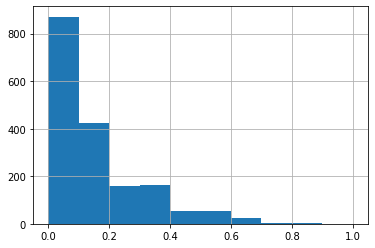

In [33]:
mw_village['FCS_low_percent'].hist()

In [34]:
percent_results_low = pd.DataFrame(columns = ['country','measure','model', 'r2']) 

model_list= [lr,lasso,elastic,rf]
country_list = ["mw","tz","ug"]
measure_list = ["FCS","rCSI"]

for model in model_list:
    for country in country_list:
        for measure in measure_list:
            if (measure=="rCSI") & (country=="ug"):
                pass
            else:
                if country=="mw":
                    df = mw_village
                elif country == "ug":
                    df = ug_village
                elif country == "tz":
                    df = tz_village
            
                percent_results_low = percent_results_low.append(r2_percent_low(country,df,measure,model),ignore_index=True)
percent_results_low                

,country,measure,model,r2
0,mw,FCS,linear_reg,0.000
1,mw,rCSI,linear_reg,0.001
2,tz,FCS,linear_reg,0.116
3,tz,rCSI,linear_reg,0.085
4,ug,FCS,linear_reg,0.037
5,mw,FCS,lasso,0.081
6,mw,rCSI,lasso,0.016
7,tz,FCS,lasso,0.117
8,tz,rCSI,lasso,0.031
9,ug,FCS,lasso,0.046


In [39]:
percent_results_mid_low = pd.DataFrame(columns = ['country','measure','model', 'r2']) 

model_list= [lr,lasso,elastic,rf]
country_list = ["mw","tz","ug"]
measure_list = ["FCS","rCSI"]

for model in model_list:
    for country in country_list:
        for measure in measure_list:
            if (measure=="rCSI") & (country=="ug"):
                pass
            else:
                if country=="mw":
                    df = mw_village
                elif country == "ug":
                    df = ug_village
                elif country == "tz":
                    df = tz_village
            
                percent_results_mid_low = percent_results_mid_low.append(r2_percent_mid_low(country,df,measure,model),ignore_index=True)
percent_results_mid_low                

,country,measure,model,r2
0,mw,FCS,linear_reg,0.008
1,mw,rCSI,linear_reg,0.000
2,tz,FCS,linear_reg,0.205
3,tz,rCSI,linear_reg,0.082
4,ug,FCS,linear_reg,0.121
5,mw,FCS,lasso,0.138
6,mw,rCSI,lasso,0.033
7,tz,FCS,lasso,0.237
8,tz,rCSI,lasso,0.094
9,ug,FCS,lasso,0.138


### Feature importance

random forest and gradient boosting model choice 

In [ ]:

    from sklearn.metrics import r2_score
    from rfpimp import permutation_importances

    def r2_rf_score(rf, X_train, y_train):
        return r2_score(y_train, rf_random.best_estimator_.predict(X_train))

    perm_imp_rfpimp = permutation_importances(rf_random.best_estimator_, X_train, y_train, r2_rf_score)

    return ax,params,perm_imp_rfpimp

In [25]:
tree_clf = DecisionTreeClassifier(random_state=66)
    
max_depth = [int(x) for x in np.linspace(3, 20, num = 10)]
max_features = [int(x) for x in np.linspace(3, 20, num = 10)]
# n_estimators = [int(x) for x in np.linspace(1, 10, num = 5)]

random_grid = {#'n_estimators': n_estimators,
                'max_features': max_features,
                'max_depth': max_depth
                #'min_samples_split': min_samples_split
                #'min_samples_leaf': min_samples_leaf}
                #'bootstrap': bootstrap
                }

tree_random = RandomizedSearchCV(estimator = tree_clf, param_distributions = random_grid,
                                n_iter = 30, cv = 3, verbose=2, random_state=666, n_jobs = -1)

X_train = mw_clust_X_train_16
y_train = mw_clust_y_train_16['FCS_category']
tree_random.fit(X_train, y_train)

from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(tree_random.best_estimator_, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())


NameError: name 'mw_clust_X_train_16' is not defined

### Error Analysis

In [ ]:
ug12 = pd.DataFrame({ 'ug12_FCS_truth':ug12_FCS_truth, 'ug_FCS_LR' : ug12_FCS_LR, 'ug_FCS_RFC' : ug12_FCS_RFC}).reset_index(drop=True)
ug_map = pd.concat([ug_ea_id.reset_index(drop=True),ug12 ], axis=1, ignore_index=True)
ug_map.columns=['ea_id','FS_year','lat_modified','lon_modified','ug12_FCS_truth','ug_FCS_LR','ug_FCS_RFC']



### Three category results 


In [ ]:
def pre_rec_f1_support_minority(y_pred,y_test):
    
    if len(precision_recall_fscore_support(y_true=y_test,y_pred=y_pred)[3])==3:
        precision = precision_recall_fscore_support(y_true=y_test,y_pred=y_pred)[0][2]
        recall = precision_recall_fscore_support(y_true=y_test,y_pred=y_pred)[1][2]
        fscore = precision_recall_fscore_support(y_true=y_test,y_pred=y_pred)[2][2]
        support = precision_recall_fscore_support(y_true=y_test,y_pred=y_pred)[3][2]

    elif len(precision_recall_fscore_support(y_true=y_test,y_pred=y_pred)[3])==2:
 #   precision = precision_recall_fscore_support(y_true=y_test,y_pred=y_pred)[0][1]
 #   recall = precision_recall_fscore_support(y_true=y_test,y_pred=y_pred)[1][1]
 #   fscore = precision_recall_fscore_support(y_true=y_test,y_pred=y_pred)[2][1]
 #   support = precision_recall_fscore_support(y_true=y_test,y_pred=y_pred)[3][1]

        precision = np.nan
        recall = np.nan
        fscore = np.nan
        support = np.nan

    accuracy = accuracy_score(y_pred,y_test)

    return precision,recall,fscore,support,accuracy    
 
def pre_rec_f1_support_mid(y_pred,y_test):

    precision = precision_recall_fscore_support(y_true=y_test,y_pred=y_pred)[0][1]
    recall = precision_recall_fscore_support(y_true=y_test,y_pred=y_pred)[1][1]
    fscore = precision_recall_fscore_support(y_true=y_test,y_pred=y_pred)[2][1]
    support = precision_recall_fscore_support(y_true=y_test,y_pred=y_pred)[3][1]
    accuracy = accuracy_score(y_pred,y_test)

    return precision,recall,fscore,support,accuracy        

def metrics_3_category_severe(country,df,measure,model):
    
    category = measure+'_3_category'
    
    df_test,df_train = year_split(country, df)
    X_train,X_test,y_train_category,y_test_category,y_train_percent,y_test_percent = separate_y(country,df_test,df_train)
    y_pred,y_test  = model(X_train,y_train_category[category],X_test,y_test_category[category])
    
    precision,recall,fscore,support,accuracy = pre_rec_f1_support_minority(y_pred,y_test)
    
    result_row = [[country,measure, model.__doc__, precision,recall,fscore,support,accuracy]]
    result_df = pd.DataFrame(result_row,columns = ['country','measure','model', 'precision','recall','fscore','support','accuracy']) 

    return result_df

def metrics_3_category_mid(country,df,measure,model):
    
    category = measure+'_3_category'
    
    df_test,df_train = year_split(country, df)
    X_train,X_test,y_train_category,y_test_category,y_train_percent,y_test_percent = separate_y(country,df_test,df_train)
    y_pred,y_test  = model(X_train,y_train_category[category],X_test,y_test_category[category])
    
    precision,recall,fscore,support,accuracy = pre_rec_f1_support_mid(y_pred,y_test)
    
    result_row = [[country,measure, model.__doc__, precision,recall,fscore,support,accuracy]]
    result_df = pd.DataFrame(result_row,columns = ['country','measure','model', 'precision','recall','fscore','support','accuracy']) 

    return result_df

# create a table of results for the third category

third_category_severe = pd.DataFrame(columns = ['country','measure','model', 'precision','recall','fscore','support','accuracy']) 

model_list= [lrCLF,treeCLF,rfCLF,xgbCLF]
country_list = ["mw","tz","ug"]
measure_list = ["FCS","rCSI"]

for model in model_list:
    for country in country_list:
        for measure in measure_list:
            if (measure=="rCSI") & (country=="ug"):
                pass
            else:
                if country=="mw":
                    df = mw_village
                elif country == "ug":
                    df = ug_village
                elif country == "tz":
                    df = tz_village
            
                third_category_severe = third_category_severe.append(metrics_3_category_severe(country,df,measure,model),ignore_index=True)
                
# create a table of results for the third category

third_category_mid= pd.DataFrame(columns = ['country','measure','model', 'precision','recall','fscore','support','accuracy']) 

model_list= [lrCLF,treeCLF,rfCLF,xgbCLF]
country_list = ["mw","tz","ug"]
measure_list = ["FCS","rCSI"]

for model in model_list:
    for country in country_list:
        for measure in measure_list:
            if (measure=="rCSI") & (country=="ug"):
                pass
            else:
                if country=="mw":
                    df = mw_village
                elif country == "ug":
                    df = ug_village
                elif country == "tz":
                    df = tz_village
            
                third_category_mid = third_category_mid.append(metrics_3_category_mid(country,df,measure,model),ignore_index=True)                

### Household level predictions